In [1]:
import pandas as pd
import datetime as dt
import pytz
import os
import glob
import holidays
import datetime as dt
from holidays import country_holidays
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import itertools

In [2]:
import statsmodels.tsa.api as tsa
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split
import pmdarima as pm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import set_config
plt.rcParams['figure.figsize']=(12,3)

In [3]:
set_config(transform_output="pandas")
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
pd.set_option('display.max_columns',50)


In [4]:
us_holidays = country_holidays('US')
us_holidays


holidays.country_holidays('US')

In [5]:
def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

In [6]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs):
    # Save each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [7]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black', method = 'ywm'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)  
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)    
    # Annotate sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    # seasons
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        # Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        # for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [8]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    # PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [9]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [10]:
crime_2001 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2001.csv')

In [11]:
crime_2002 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2002.csv')

In [12]:
crime_2003 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2003.csv')

In [13]:
crime_2004= pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2004.csv')

In [14]:
crime_2005 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2005.csv')

In [15]:
crime_2006 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2006.csv')

In [16]:
crime_2007 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2007.csv')

In [17]:
crime_2008 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2008.csv')

In [18]:
crime_2009 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2009.csv')

In [19]:
crime_2010 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2010.csv')

In [20]:
crime_2011 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2011.csv')

In [21]:
crime_2012 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2012.csv')

In [22]:
crime_2013 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2013.csv')

In [23]:
crime_2014 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2014.csv')

In [24]:
crime_2015 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2015.csv')

In [25]:
crime_2016= pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2016.csv')

In [26]:
crime_2017 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2017.csv')

In [27]:
crime_2018 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2018.csv')

In [28]:
crime_2019 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2019.csv')

In [29]:
crime_2020 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2020.csv')

In [30]:
crime_2021 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2021.csv')

In [31]:
crime_2022 = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/chicago_crime/Data/Chicago-Crime_2022.csv')

In [32]:
all_years = [crime_2001, crime_2002, crime_2003, crime_2004, 
             crime_2005, crime_2006, crime_2007, crime_2008, 
             crime_2009, crime_2010, crime_2011, crime_2012,
             crime_2013, crime_2014, crime_2015, crime_2016,
             crime_2017, crime_2018, crime_2019, crime_2020,
             crime_2021, crime_2022]

In [33]:
all_data = pd.concat(all_years)

In [34]:
all_years = pd.concat(all_years)
all_years

ID                    Date        Primary Type  \
0        1326041  01/01/2001 01:00:00 AM             BATTERY   
1        1319931  01/01/2001 01:00:00 PM             BATTERY   
2        1324743  01/01/2001 01:00:00 PM            GAMBLING   
3        1310717  01/01/2001 01:00:00 AM     CRIMINAL DAMAGE   
4        1318099  01/01/2001 01:00:00 AM             BATTERY   
...          ...                     ...                 ...   
238853  12938029  12/31/2022 12:50:00 PM             ASSAULT   
238854  12937822  12/31/2022 12:50:00 PM             ASSAULT   
238855  12937583  12/31/2022 12:52:00 AM             BATTERY   
238856  12938420  12/31/2022 12:52:00 PM             ASSAULT   
238857  12939906  12/31/2022 12:59:00 PM  DECEPTIVE PRACTICE   

                                    Description          Location Description  \
0                                        SIMPLE                     RESIDENCE   
1                                        SIMPLE                     RESIDENCE   
2                           ILLEGAL ILL LOTTERY                        STREET   
3                                    TO VEHICLE                        STREET   
4                                        SIMPLE       RESIDENCE PORCH/HALLWAY   
...                                         ...                           ...   
238853                                   SIMPLE                     APARTMENT   
238854                     AGGRAVATED - HANDGUN                     APARTMENT   
238855                                   SIMPLE                    BARBERSHOP   
238856                                   SIMPLE  COMMERCIAL / BUSINESS OFFICE   
238857  FINANCIAL IDENTITY THEFT $300 AND UNDER                     RESIDENCE   

        Arrest  Domestic  Beat  District  Ward   Latitude  Longitude  
0        False     False  1624      16.0   NaN  41.957850 -87.749185  
1        False      True   825       8.0   NaN  41.783892 -87.684841  
2         True     False   313       3.0   NaN  41.780412 -87.611970  
3        False     False  2424      24.0   NaN  42.012391 -87.678032  
4        False      True   214       2.0   NaN  41.819538 -87.620020  
...        ...       ...   ...       ...   ...        ...        ...  
238853   False     False  1014      10.0  24.0  41.855911 -87.719966  
238854   False      True   733       7.0   6.0  41.766546 -87.645669  
238855   False     False  1135      11.0  28.0  41.868829 -87.686098  
238856   False     False  1432      14.0  32.0  41.930693 -87.685657  
238857   False     False  1511      15.0  29.0        NaN        NaN  

[7713109 rows x 12 columns]

In [35]:
all_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 662.0+ MB


In [36]:
all_years['Date'] = pd.to_datetime(all_years['Date'], format = '%m/%d/%Y %H:%M:%S %p')

In [37]:
all_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Date                  datetime64[ns]
 2   Primary Type          object        
 3   Description           object        
 4   Location Description  object        
 5   Arrest                bool          
 6   Domestic              bool          
 7   Beat                  int64         
 8   District              float64       
 9   Ward                  float64       
 10  Latitude              float64       
 11  Longitude             float64       
dtypes: bool(2), datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 662.0+ MB


In [38]:
all_years = all_years.set_index(['Date'])
all_years

ID        Primary Type  \
Date                                                
2001-01-01 01:00:00   1326041             BATTERY   
2001-01-01 01:00:00   1319931             BATTERY   
2001-01-01 01:00:00   1324743            GAMBLING   
2001-01-01 01:00:00   1310717     CRIMINAL DAMAGE   
2001-01-01 01:00:00   1318099             BATTERY   
...                       ...                 ...   
2022-12-31 12:50:00  12938029             ASSAULT   
2022-12-31 12:50:00  12937822             ASSAULT   
2022-12-31 12:52:00  12937583             BATTERY   
2022-12-31 12:52:00  12938420             ASSAULT   
2022-12-31 12:59:00  12939906  DECEPTIVE PRACTICE   

                                                 Description  \
Date                                                           
2001-01-01 01:00:00                                   SIMPLE   
2001-01-01 01:00:00                                   SIMPLE   
2001-01-01 01:00:00                      ILLEGAL ILL LOTTERY   
2001-01-01 01:00:00                               TO VEHICLE   
2001-01-01 01:00:00                                   SIMPLE   
...                                                      ...   
2022-12-31 12:50:00                                   SIMPLE   
2022-12-31 12:50:00                     AGGRAVATED - HANDGUN   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:59:00  FINANCIAL IDENTITY THEFT $300 AND UNDER   

                             Location Description  Arrest  Domestic  Beat  \
Date                                                                        
2001-01-01 01:00:00                     RESIDENCE   False     False  1624   
2001-01-01 01:00:00                     RESIDENCE   False      True   825   
2001-01-01 01:00:00                        STREET    True     False   313   
2001-01-01 01:00:00                        STREET   False     False  2424   
2001-01-01 01:00:00       RESIDENCE PORCH/HALLWAY   False      True   214   
...                                           ...     ...       ...   ...   
2022-12-31 12:50:00                     APARTMENT   False     False  1014   
2022-12-31 12:50:00                     APARTMENT   False      True   733   
2022-12-31 12:52:00                    BARBERSHOP   False     False  1135   
2022-12-31 12:52:00  COMMERCIAL / BUSINESS OFFICE   False     False  1432   
2022-12-31 12:59:00                     RESIDENCE   False     False  1511   

                     District  Ward   Latitude  Longitude  
Date                                                       
2001-01-01 01:00:00      16.0   NaN  41.957850 -87.749185  
2001-01-01 01:00:00       8.0   NaN  41.783892 -87.684841  
2001-01-01 01:00:00       3.0   NaN  41.780412 -87.611970  
2001-01-01 01:00:00      24.0   NaN  42.012391 -87.678032  
2001-01-01 01:00:00       2.0   NaN  41.819538 -87.620020  
...                       ...   ...        ...        ...  
2022-12-31 12:50:00      10.0  24.0  41.855911 -87.719966  
2022-12-31 12:50:00       7.0   6.0  41.766546 -87.645669  
2022-12-31 12:52:00      11.0  28.0  41.868829 -87.686098  
2022-12-31 12:52:00      14.0  32.0  41.930693 -87.685657  
2022-12-31 12:59:00      15.0  29.0        NaN        NaN  

[7713109 rows x 11 columns]

In [39]:
all_years.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7713109 entries, 2001-01-01 01:00:00 to 2022-12-31 12:59:00
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Primary Type          object 
 2   Description           object 
 3   Location Description  object 
 4   Arrest                bool   
 5   Domestic              bool   
 6   Beat                  int64  
 7   District              float64
 8   Ward                  float64
 9   Latitude              float64
 10  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(3)
memory usage: 603.2+ MB


# Stakeholder Questions

## Topic 1) Comparing Police Districts

In [40]:
year_2022 = all_years.loc['2022']
year_2022

ID        Primary Type  \
Date                                                
2022-01-01 01:00:00  12582293               THEFT   
2022-01-01 01:00:00  12607313  DECEPTIVE PRACTICE   
2022-01-01 01:00:00  12585671     CRIMINAL DAMAGE   
2022-01-01 01:00:00  12592889       OTHER OFFENSE   
2022-01-01 01:00:00  12584977               THEFT   
...                       ...                 ...   
2022-12-31 12:50:00  12938029             ASSAULT   
2022-12-31 12:50:00  12937822             ASSAULT   
2022-12-31 12:52:00  12937583             BATTERY   
2022-12-31 12:52:00  12938420             ASSAULT   
2022-12-31 12:59:00  12939906  DECEPTIVE PRACTICE   

                                                 Description  \
Date                                                           
2022-01-01 01:00:00                           $500 AND UNDER   
2022-01-01 01:00:00  FINANCIAL IDENTITY THEFT $300 AND UNDER   
2022-01-01 01:00:00                               TO VEHICLE   
2022-01-01 01:00:00                  HARASSMENT BY TELEPHONE   
2022-01-01 01:00:00                           $500 AND UNDER   
...                                                      ...   
2022-12-31 12:50:00                                   SIMPLE   
2022-12-31 12:50:00                     AGGRAVATED - HANDGUN   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:59:00  FINANCIAL IDENTITY THEFT $300 AND UNDER   

                                       Location Description  Arrest  Domestic  \
Date                                                                            
2022-01-01 01:00:00                              RESTAURANT   False     False   
2022-01-01 01:00:00                                    BANK   False     False   
2022-01-01 01:00:00  PARKING LOT / GARAGE (NON RESIDENTIAL)   False     False   
2022-01-01 01:00:00                               APARTMENT   False     False   
2022-01-01 01:00:00                         OTHER (SPECIFY)   False     False   
...                                                     ...     ...       ...   
2022-12-31 12:50:00                               APARTMENT   False     False   
2022-12-31 12:50:00                               APARTMENT   False      True   
2022-12-31 12:52:00                              BARBERSHOP   False     False   
2022-12-31 12:52:00            COMMERCIAL / BUSINESS OFFICE   False     False   
2022-12-31 12:59:00                               RESIDENCE   False     False   

                     Beat  District  Ward   Latitude  Longitude  
Date                                                             
2022-01-01 01:00:00   121       1.0  42.0  41.881884 -87.640060  
2022-01-01 01:00:00   811       8.0  23.0  41.787923 -87.769446  
2022-01-01 01:00:00   531       5.0   9.0  41.687443 -87.604120  
2022-01-01 01:00:00   412       4.0   8.0  41.734353 -87.585147  
2022-01-01 01:00:00  1811      18.0   2.0  41.910818 -87.654560  
...                   ...       ...   ...        ...        ...  
2022-12-31 12:50:00  1014      10.0  24.0  41.855911 -87.719966  
2022-12-31 12:50:00   733       7.0   6.0  41.766546 -87.645669  
2022-12-31 12:52:00  1135      11.0  28.0  41.868829 -87.686098  
2022-12-31 12:52:00  1432      14.0  32.0  41.930693 -87.685657  
2022-12-31 12:59:00  1511      15.0  29.0        NaN        NaN  

[238858 rows x 11 columns]

In [41]:
district_crime_22 = year_2022[['District', 'Primary Type']]
district_crime_22

District        Primary Type
Date                                             
2022-01-01 01:00:00       1.0               THEFT
2022-01-01 01:00:00       8.0  DECEPTIVE PRACTICE
2022-01-01 01:00:00       5.0     CRIMINAL DAMAGE
2022-01-01 01:00:00       4.0       OTHER OFFENSE
2022-01-01 01:00:00      18.0               THEFT
...                       ...                 ...
2022-12-31 12:50:00      10.0             ASSAULT
2022-12-31 12:50:00       7.0             ASSAULT
2022-12-31 12:52:00      11.0             BATTERY
2022-12-31 12:52:00      14.0             ASSAULT
2022-12-31 12:59:00      15.0  DECEPTIVE PRACTICE

[238858 rows x 2 columns]

In [42]:
crime_22 = district_crime_22.groupby(['District']).count().copy()
crime_22

Primary Type
District              
1.0              13044
2.0              11793
3.0              11937
4.0              13931
5.0               9773
6.0              14694
7.0              10319
8.0              14805
9.0              10376
10.0              9961
11.0             13457
12.0             14341
14.0              8158
15.0              8308
16.0              9226
17.0              6997
18.0             12429
19.0             12243
20.0              4960
22.0              7671
24.0              8469
25.0             11951
31.0                15

In [43]:
crime_22.sort_values(by='Primary Type', ascending=False)

Primary Type
District              
8.0              14805
6.0              14694
12.0             14341
4.0              13931
11.0             13457
1.0              13044
18.0             12429
19.0             12243
25.0             11951
3.0              11937
2.0              11793
9.0              10376
7.0              10319
10.0              9961
5.0               9773
16.0              9226
24.0              8469
15.0              8308
14.0              8158
22.0              7671
17.0              6997
20.0              4960
31.0                15

District 8 had the most crimes

Distriect 31 had the least crimes

## Topic 2) Crimes Across the Years

In [44]:
all_crimes = all_years[['Primary Type']]
df_resample = all_crimes.resample('A').count().copy()
df_resample

Primary Type
Date                    
2001-12-31        485886
2002-12-31        486807
2003-12-31        475985
2004-12-31        469422
2005-12-31        453773
2006-12-31        448179
2007-12-31        437087
2008-12-31        427183
2009-12-31        392827
2010-12-31        370513
2011-12-31        351993
2012-12-31        336319
2013-12-31        307536
2014-12-31        275789
2015-12-31        264787
2016-12-31        269823
2017-12-31        269100
2018-12-31        268899
2019-12-31        261325
2020-12-31        212194
2021-12-31        208824
2022-12-31        238858

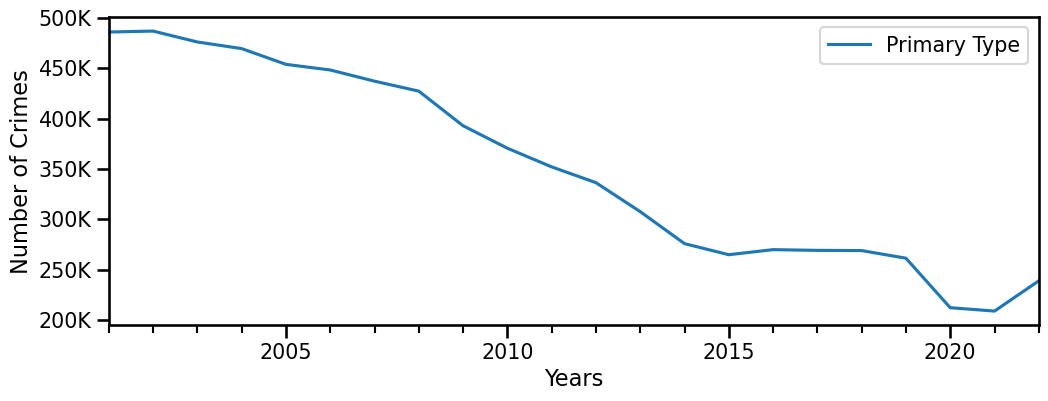

In [45]:
ax = df_resample.plot()
ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Years')
ax.yaxis.set_major_formatter(fmt_thous);

the total number of crimes seems to be decreasing over time

In [46]:
crime_counts = all_crimes.groupby('Primary Type').value_counts().sort_index()
crime_counts

Primary Type
ARSON                                  13121
ASSAULT                               501103
BATTERY                              1410889
BURGLARY                              422246
CONCEALED CARRY LICENSE VIOLATION       1019
CRIM SEXUAL ASSAULT                    27584
CRIMINAL DAMAGE                       878914
CRIMINAL SEXUAL ASSAULT                 6353
CRIMINAL TRESPASS                     212869
DECEPTIVE PRACTICE                    340958
DOMESTIC VIOLENCE                          1
GAMBLING                               14616
HOMICIDE                               12394
HUMAN TRAFFICKING                         96
INTERFERENCE WITH PUBLIC OFFICER       18206
INTIMIDATION                            4595
KIDNAPPING                              7185
LIQUOR LAW VIOLATION                   14846
MOTOR VEHICLE THEFT                   366586
NARCOTICS                             746155
NON - CRIMINAL                            38
NON-CRIMINAL                             1

In [47]:
crime_plot = all_crimes[['Primary Type']]

In [48]:
crime_plot

Primary Type
Date                                   
2001-01-01 01:00:00             BATTERY
2001-01-01 01:00:00             BATTERY
2001-01-01 01:00:00            GAMBLING
2001-01-01 01:00:00     CRIMINAL DAMAGE
2001-01-01 01:00:00             BATTERY
...                                 ...
2022-12-31 12:50:00             ASSAULT
2022-12-31 12:50:00             ASSAULT
2022-12-31 12:52:00             BATTERY
2022-12-31 12:52:00             ASSAULT
2022-12-31 12:59:00  DECEPTIVE PRACTICE

[7713109 rows x 1 columns]

In [49]:
crime_plot.value_counts()

Primary Type                     
THEFT                                1626992
BATTERY                              1410889
CRIMINAL DAMAGE                       878914
NARCOTICS                             746155
ASSAULT                               501103
OTHER OFFENSE                         479174
BURGLARY                              422246
MOTOR VEHICLE THEFT                   366586
DECEPTIVE PRACTICE                    340958
ROBBERY                               289677
CRIMINAL TRESPASS                     212869
WEAPONS VIOLATION                     103906
PROSTITUTION                           69750
OFFENSE INVOLVING CHILDREN             55280
PUBLIC PEACE VIOLATION                 52086
SEX OFFENSE                            30442
CRIM SEXUAL ASSAULT                    27584
INTERFERENCE WITH PUBLIC OFFICER       18206
LIQUOR LAW VIOLATION                   14846
GAMBLING                               14616
ARSON                                  13121
HOMICIDE             

In [50]:
all_years['Year'] = all_years.index.year

In [51]:
all_years

ID        Primary Type  \
Date                                                
2001-01-01 01:00:00   1326041             BATTERY   
2001-01-01 01:00:00   1319931             BATTERY   
2001-01-01 01:00:00   1324743            GAMBLING   
2001-01-01 01:00:00   1310717     CRIMINAL DAMAGE   
2001-01-01 01:00:00   1318099             BATTERY   
...                       ...                 ...   
2022-12-31 12:50:00  12938029             ASSAULT   
2022-12-31 12:50:00  12937822             ASSAULT   
2022-12-31 12:52:00  12937583             BATTERY   
2022-12-31 12:52:00  12938420             ASSAULT   
2022-12-31 12:59:00  12939906  DECEPTIVE PRACTICE   

                                                 Description  \
Date                                                           
2001-01-01 01:00:00                                   SIMPLE   
2001-01-01 01:00:00                                   SIMPLE   
2001-01-01 01:00:00                      ILLEGAL ILL LOTTERY   
2001-01-01 01:00:00                               TO VEHICLE   
2001-01-01 01:00:00                                   SIMPLE   
...                                                      ...   
2022-12-31 12:50:00                                   SIMPLE   
2022-12-31 12:50:00                     AGGRAVATED - HANDGUN   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:59:00  FINANCIAL IDENTITY THEFT $300 AND UNDER   

                             Location Description  Arrest  Domestic  Beat  \
Date                                                                        
2001-01-01 01:00:00                     RESIDENCE   False     False  1624   
2001-01-01 01:00:00                     RESIDENCE   False      True   825   
2001-01-01 01:00:00                        STREET    True     False   313   
2001-01-01 01:00:00                        STREET   False     False  2424   
2001-01-01 01:00:00       RESIDENCE PORCH/HALLWAY   False      True   214   
...                                           ...     ...       ...   ...   
2022-12-31 12:50:00                     APARTMENT   False     False  1014   
2022-12-31 12:50:00                     APARTMENT   False      True   733   
2022-12-31 12:52:00                    BARBERSHOP   False     False  1135   
2022-12-31 12:52:00  COMMERCIAL / BUSINESS OFFICE   False     False  1432   
2022-12-31 12:59:00                     RESIDENCE   False     False  1511   

                     District  Ward   Latitude  Longitude  Year  
Date                                                             
2001-01-01 01:00:00      16.0   NaN  41.957850 -87.749185  2001  
2001-01-01 01:00:00       8.0   NaN  41.783892 -87.684841  2001  
2001-01-01 01:00:00       3.0   NaN  41.780412 -87.611970  2001  
2001-01-01 01:00:00      24.0   NaN  42.012391 -87.678032  2001  
2001-01-01 01:00:00       2.0   NaN  41.819538 -87.620020  2001  
...                       ...   ...        ...        ...   ...  
2022-12-31 12:50:00      10.0  24.0  41.855911 -87.719966  2022  
2022-12-31 12:50:00       7.0   6.0  41.766546 -87.645669  2022  
2022-12-31 12:52:00      11.0  28.0  41.868829 -87.686098  2022  
2022-12-31 12:52:00      14.0  32.0  41.930693 -87.685657  2022  
2022-12-31 12:59:00      15.0  29.0        NaN        NaN  2022  

[7713109 rows x 12 columns]

In [52]:
ay2 = all_years.drop(columns=['ID', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Latitude', 'Longitude', 'Year']).copy()

In [53]:
ay2

Primary Type
Date                                   
2001-01-01 01:00:00             BATTERY
2001-01-01 01:00:00             BATTERY
2001-01-01 01:00:00            GAMBLING
2001-01-01 01:00:00     CRIMINAL DAMAGE
2001-01-01 01:00:00             BATTERY
...                                 ...
2022-12-31 12:50:00             ASSAULT
2022-12-31 12:50:00             ASSAULT
2022-12-31 12:52:00             BATTERY
2022-12-31 12:52:00             ASSAULT
2022-12-31 12:59:00  DECEPTIVE PRACTICE

[7713109 rows x 1 columns]

In [54]:
ay2.index

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               ...
               '2022-12-31 12:41:00', '2022-12-31 12:42:00',
               '2022-12-31 12:44:00', '2022-12-31 12:45:00',
               '2022-12-31 12:45:00', '2022-12-31 12:50:00',
               '2022-12-31 12:50:00', '2022-12-31 12:52:00',
               '2022-12-31 12:52:00', '2022-12-31 12:59:00'],
              dtype='datetime64[ns]', name='Date', length=7713109, freq=None)

In [55]:
ay3 = ay2.groupby('Primary Type').resample('A').count()
ay3

Primary Type
Primary Type      Date                    
ARSON             2001-12-31          1011
                  2002-12-31          1032
                  2003-12-31           955
                  2004-12-31           778
                  2005-12-31           691
...                                    ...
WEAPONS VIOLATION 2018-12-31          5456
                  2019-12-31          6339
                  2020-12-31          8432
                  2021-12-31          8980
                  2022-12-31          8766

[723 rows x 1 columns]

In [56]:
all_crime_counts = ay3.unstack(level=0)

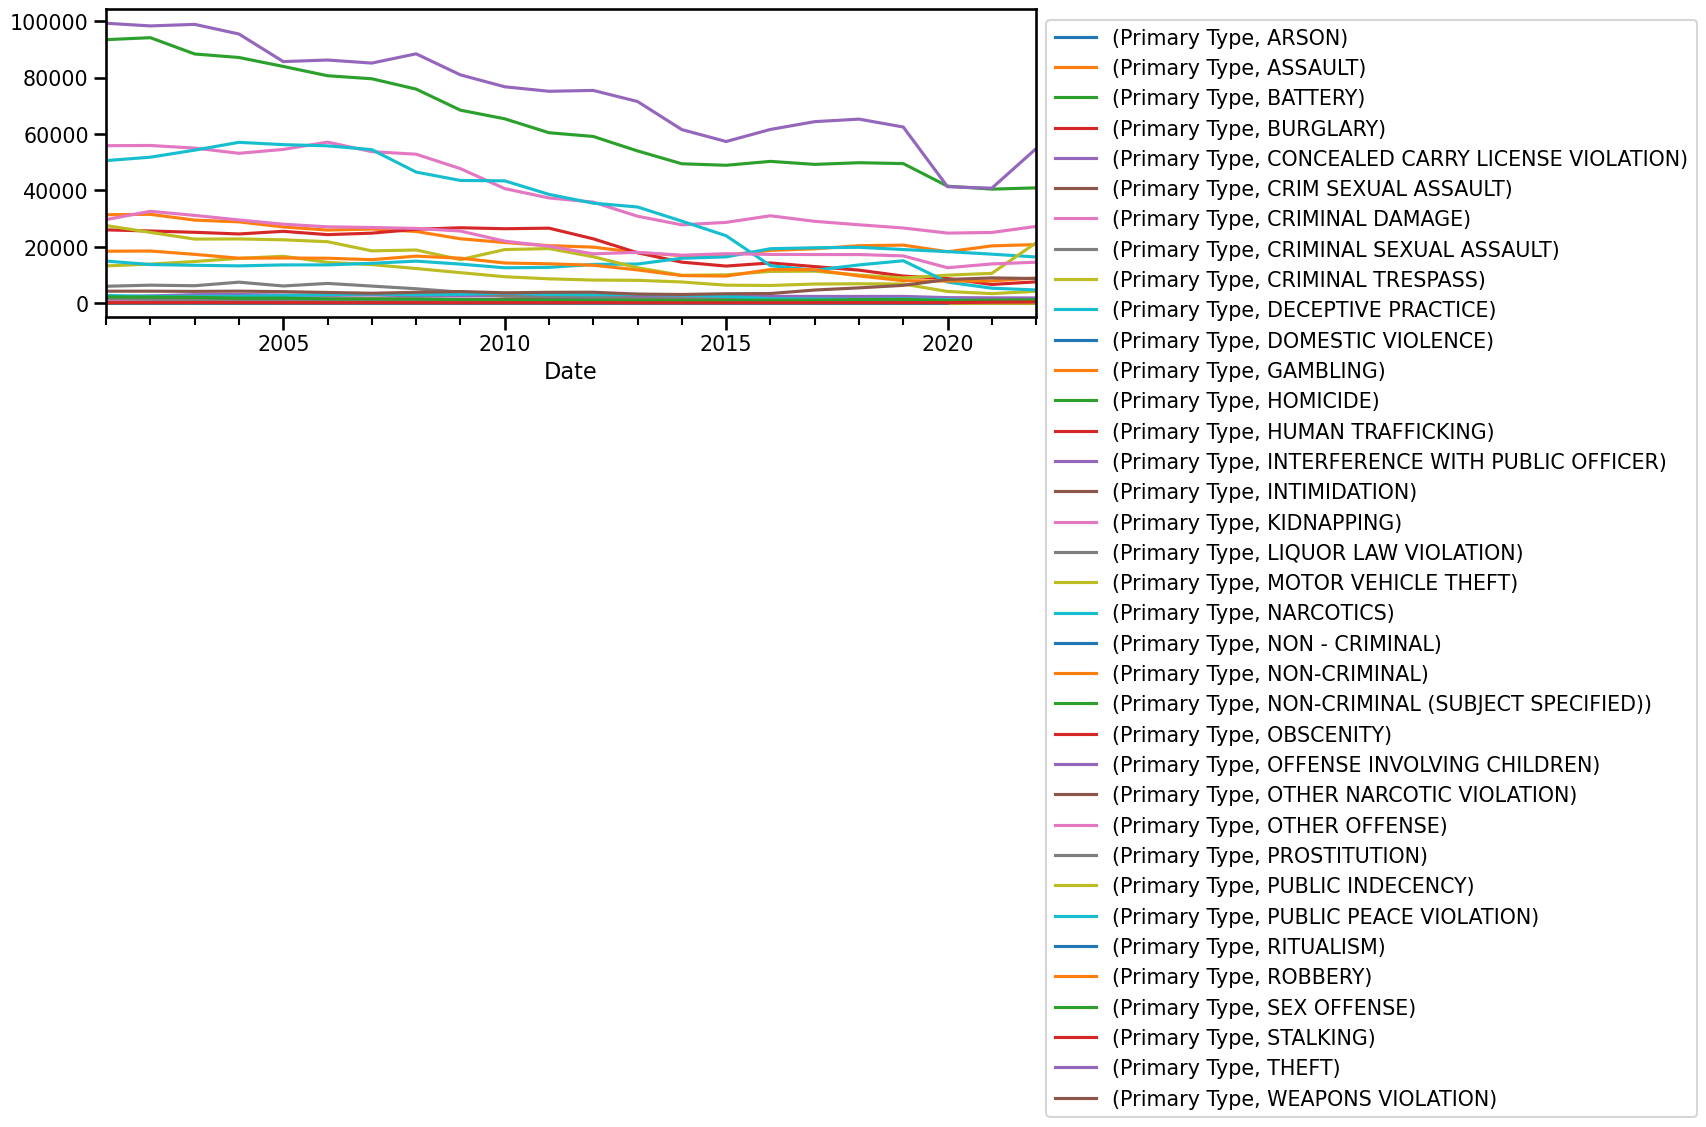

In [57]:
all_crime_counts.plot()
plt.legend(bbox_to_anchor=(1,1));

most crime is going down but theft seems to be going back up

In [58]:
all_crime_counts

Primary Type                             \
Primary Type        ARSON  ASSAULT  BATTERY BURGLARY   
Date                                                   
2001-12-31         1011.0  31384.0  93461.0  26014.0   
2002-12-31         1032.0  31523.0  94153.0  25623.0   
2003-12-31          955.0  29477.0  88380.0  25157.0   
2004-12-31          778.0  28850.0  87136.0  24564.0   
2005-12-31          691.0  27067.0  83964.0  25503.0   
2006-12-31          726.0  25945.0  80666.0  24324.0   
2007-12-31          712.0  26313.0  79593.0  24858.0   
2008-12-31          644.0  25448.0  75930.0  26218.0   
2009-12-31          616.0  22861.0  68460.0  26767.0   
2010-12-31          522.0  21537.0  65401.0  26422.0   
2011-12-31          504.0  20411.0  60459.0  26620.0   
2012-12-31          469.0  19900.0  59134.0  22845.0   
2013-12-31          364.0  17972.0  54006.0  17895.0   
2014-12-31          397.0  16903.0  49453.0  14569.0   
2015-12-31          453.0  17048.0  48923.0  13184.0   
2016-12-31          516.0  18742.0  50300.0  14289.0   
2017-12-31          444.0  19306.0  49239.0  13001.0   
2018-12-31          373.0  20406.0  49828.0  11747.0   
2019-12-31          376.0  20620.0  49517.0   9638.0   
2020-12-31          588.0  18252.0  41513.0   8757.0   
2021-12-31          529.0  20342.0  40462.0   6659.0   
2022-12-31          421.0  20796.0  40911.0   7592.0   

                                                                    \
Primary Type CONCEALED CARRY LICENSE VIOLATION CRIM SEXUAL ASSAULT   
Date                                                                 
2001-12-31                                 1.0              1779.0   
2002-12-31                                 0.0              1807.0   
2003-12-31                                 0.0              1571.0   
2004-12-31                                 0.0              1538.0   
2005-12-31                                 0.0              1521.0   
2006-12-31                                 0.0              1439.0   
2007-12-31                                 0.0              1507.0   
2008-12-31                                 0.0              1515.0   
2009-12-31                                 0.0              1401.0   
2010-12-31                                 0.0              1335.0   
2011-12-31                                 0.0              1459.0   
2012-12-31                                 0.0              1392.0   
2013-12-31                                 0.0              1271.0   
2014-12-31                                15.0              1312.0   
2015-12-31                                34.0              1352.0   
2016-12-31                                36.0              1497.0   
2017-12-31                                69.0              1506.0   
2018-12-31                               149.0              1399.0   
2019-12-31                               217.0               908.0   
2020-12-31                               148.0                75.0   
2021-12-31                               173.0                 NaN   
2022-12-31                               177.0                 NaN   

                                                                        \
Primary Type CRIMINAL DAMAGE CRIMINAL SEXUAL ASSAULT CRIMINAL TRESPASS   
Date                                                                     
2001-12-31           55859.0                    29.0           13241.0   
2002-12-31           55941.0                    27.0           13880.0   
2003-12-31           55011.0                    41.0           14807.0   
2004-12-31           53164.0                    42.0           15913.0   
2005-12-31           54548.0                    37.0           16655.0   
2006-12-31           57124.0                    47.0           14505.0   
2007-12-31           53749.0                    53.0           13699.0   
2008-12-31           52843.0                    47.0           12310.0   
2009-12-31           47725.0                   

## Topic 4) Comparing Months

In [59]:
all_years['Month'] = all_years.index.month
all_years['Month'] = all_years['Month']

In [60]:
all_years['Month'].value_counts()

7     717232
8     710444
5     682932
6     681739
10    676285
9     668242
3     629704
4     627175
11    608961
1     601236
12    579768
2     529391
Name: Month, dtype: int64

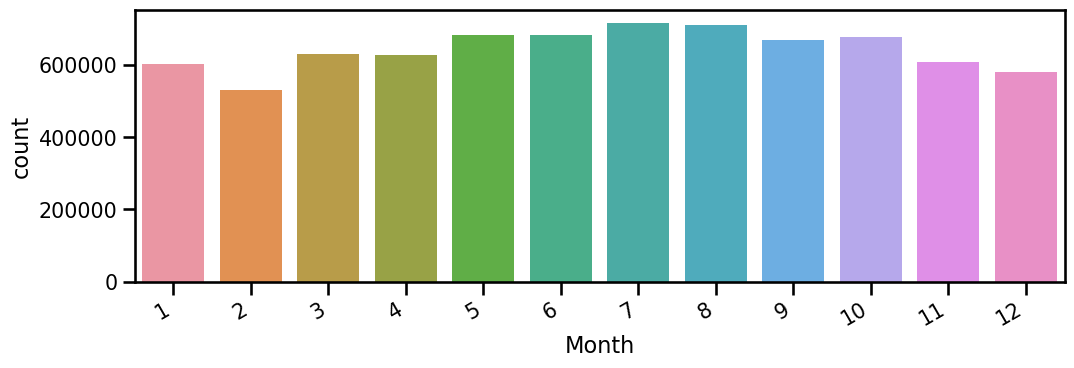

In [61]:
ax = sns.countplot(data = all_years, x=('Month'))
fig = ax.get_figure()
fig.autofmt_xdate()

In [62]:
crimes_by_month = all_years.groupby('Primary Type')['Month'].value_counts().sort_index()
crimes_by_month

Primary Type       Month
ARSON              1         917
                   2         807
                   3        1111
                   4        1097
                   5        1230
                            ... 
WEAPONS VIOLATION  8        9887
                   9        9435
                   10       9190
                   11       7952
                   12       7401
Name: Month, Length: 415, dtype: int64

In [63]:
month_crime_df = crimes_by_month.to_frame('Crimes').reset_index()
month_crime_df

Primary Type  Month  Crimes
0                ARSON      1     917
1                ARSON      2     807
2                ARSON      3    1111
3                ARSON      4    1097
4                ARSON      5    1230
..                 ...    ...     ...
410  WEAPONS VIOLATION      8    9887
411  WEAPONS VIOLATION      9    9435
412  WEAPONS VIOLATION     10    9190
413  WEAPONS VIOLATION     11    7952
414  WEAPONS VIOLATION     12    7401

[415 rows x 3 columns]

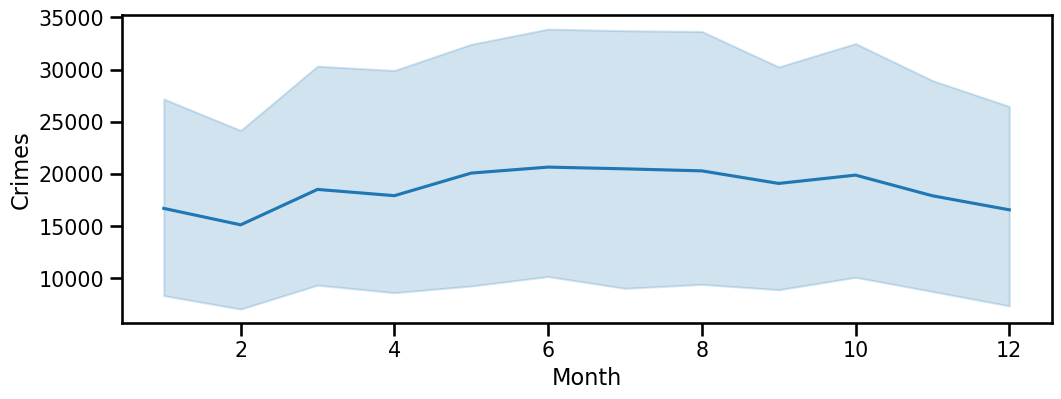

In [64]:
ax = sns.lineplot(data = month_crime_df, x = 'Month', y = 'Crimes')

It appears as there is more crime during the warmer months (May through August)

February seems to be the month with the least amount of crimem, quite possibly because of how cold it is

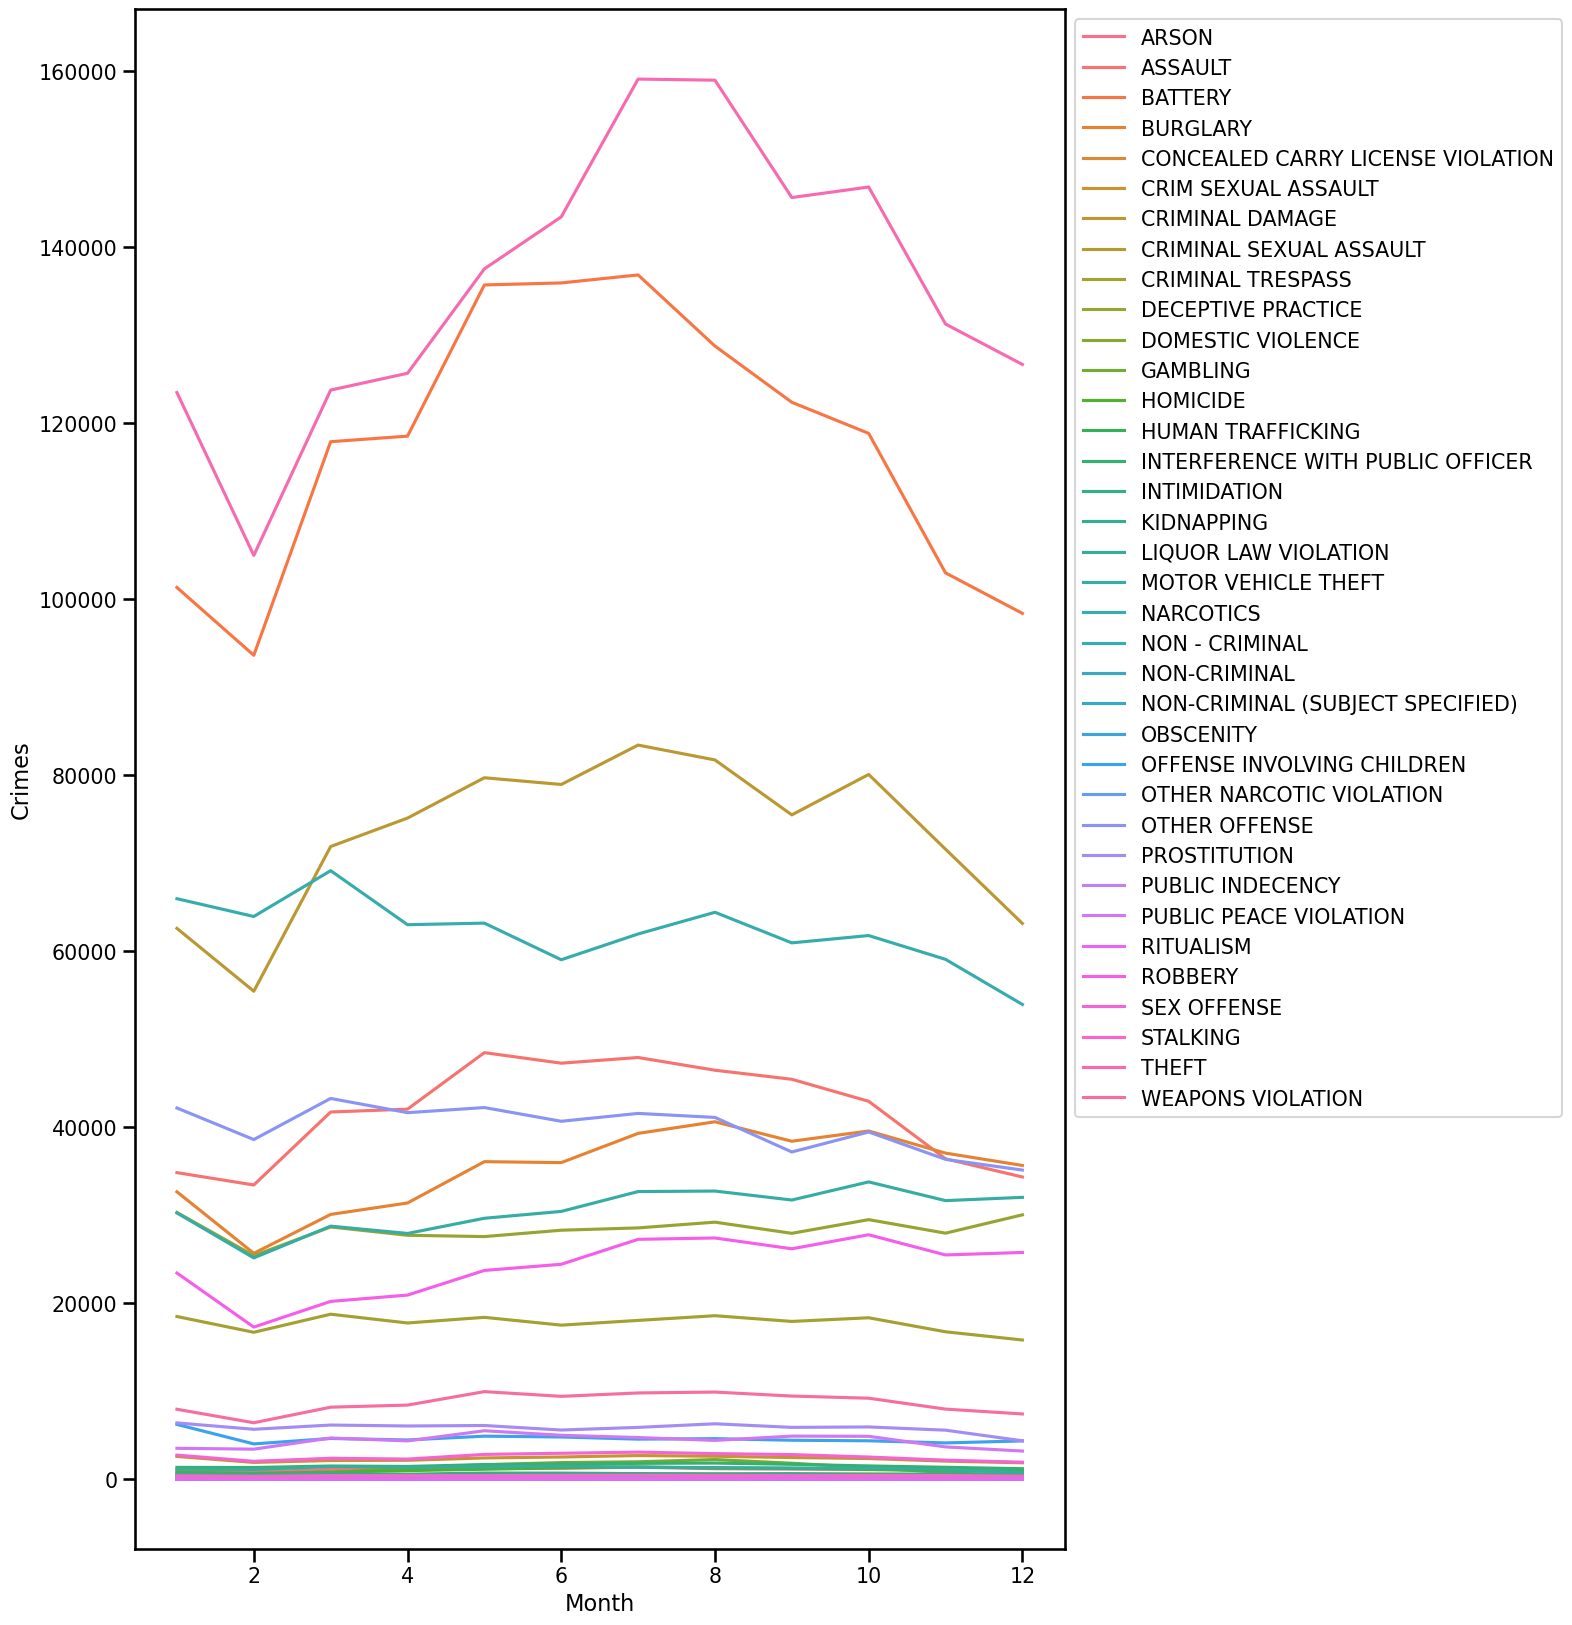

In [65]:
fig, ax = plt.subplots(figsize = (12,20))
sns.lineplot(data = month_crime_df, x = 'Month', y = 'Crimes', markers = True, hue = 'Primary Type', ax = ax)
ax.legend(bbox_to_anchor=[1, 1]);

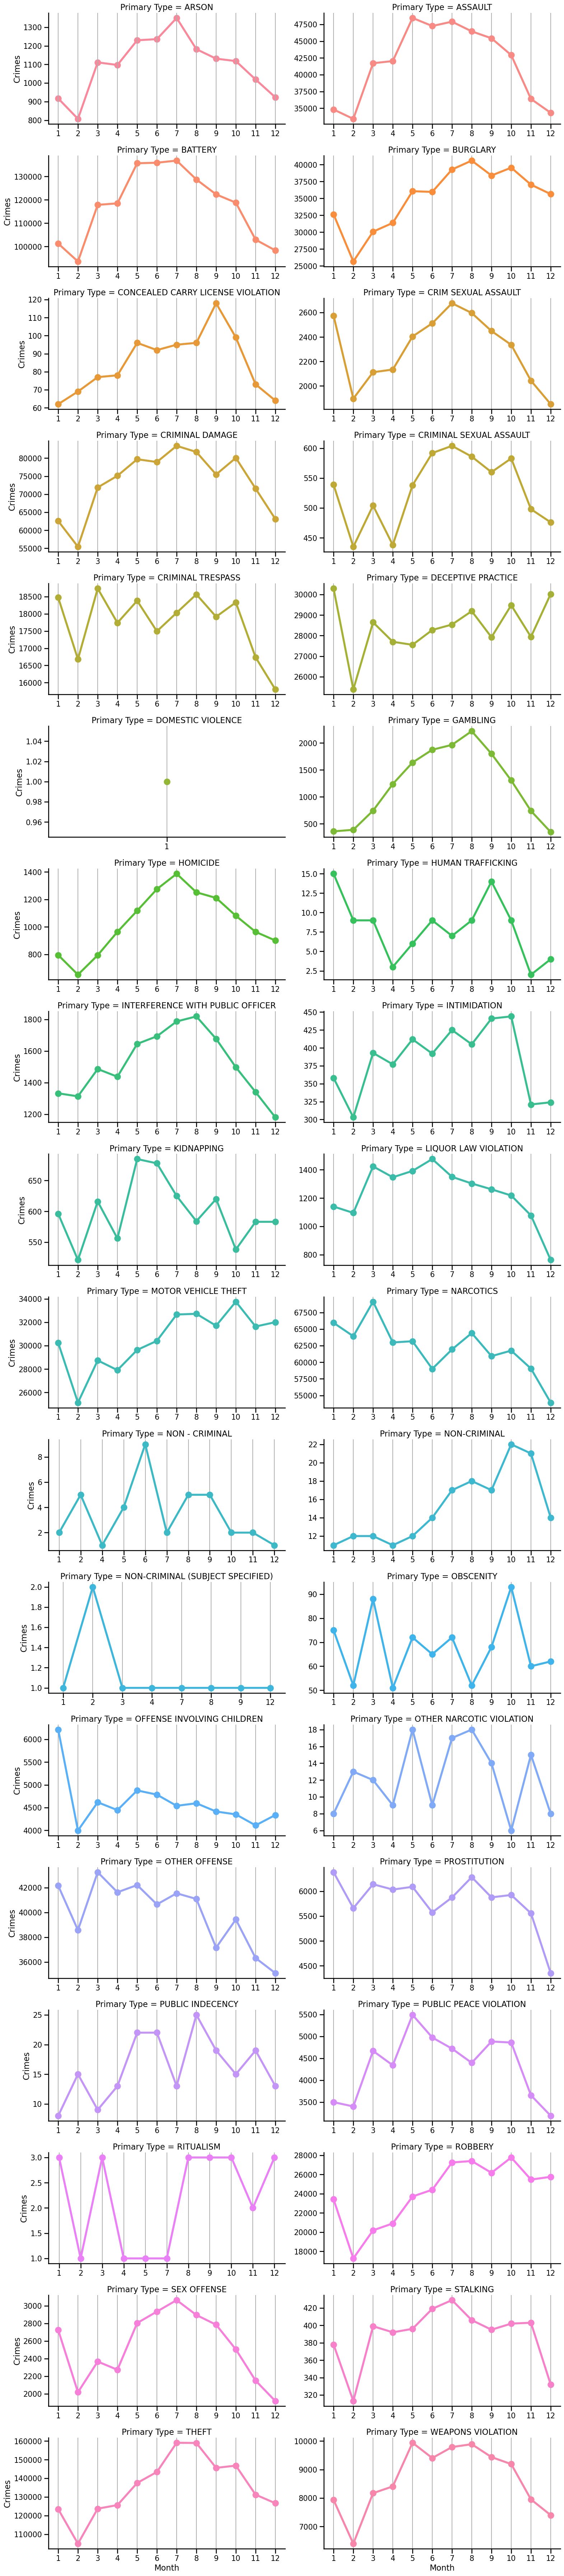

In [66]:
g = sns.catplot(data = month_crime_df, x = 'Month', y = 'Crimes', kind = 'point', aspect=2, height = 4, hue = 'Primary Type',
               col = 'Primary Type', col_wrap = 2, sharey = False, sharex = False)
[ax.grid(axis='x') for ax in g.axes];

In terms of individual crimes, it seems as though public indecency, prostitution, narcotics, trespassing, and human trafficing seem to be up in february, while most other crimes are down.


Chicago may not the best place to visit for valentines day

# Part 2

In [127]:
all_years

ID        Primary Type  \
Date                                                
2001-01-01 01:00:00   1326041             BATTERY   
2001-01-01 01:00:00   1319931             BATTERY   
2001-01-01 01:00:00   1324743            GAMBLING   
2001-01-01 01:00:00   1310717     CRIMINAL DAMAGE   
2001-01-01 01:00:00   1318099             BATTERY   
...                       ...                 ...   
2022-12-31 12:50:00  12938029             ASSAULT   
2022-12-31 12:50:00  12937822             ASSAULT   
2022-12-31 12:52:00  12937583             BATTERY   
2022-12-31 12:52:00  12938420             ASSAULT   
2022-12-31 12:59:00  12939906  DECEPTIVE PRACTICE   

                                                 Description  \
Date                                                           
2001-01-01 01:00:00                                   SIMPLE   
2001-01-01 01:00:00                                   SIMPLE   
2001-01-01 01:00:00                      ILLEGAL ILL LOTTERY   
2001-01-01 01:00:00                               TO VEHICLE   
2001-01-01 01:00:00                                   SIMPLE   
...                                                      ...   
2022-12-31 12:50:00                                   SIMPLE   
2022-12-31 12:50:00                     AGGRAVATED - HANDGUN   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:59:00  FINANCIAL IDENTITY THEFT $300 AND UNDER   

                             Location Description  Arrest  Domestic  Beat  \
Date                                                                        
2001-01-01 01:00:00                     RESIDENCE   False     False  1624   
2001-01-01 01:00:00                     RESIDENCE   False      True   825   
2001-01-01 01:00:00                        STREET    True     False   313   
2001-01-01 01:00:00                        STREET   False     False  2424   
2001-01-01 01:00:00       RESIDENCE PORCH/HALLWAY   False      True   214   
...                                           ...     ...       ...   ...   
2022-12-31 12:50:00                     APARTMENT   False     False  1014   
2022-12-31 12:50:00                     APARTMENT   False      True   733   
2022-12-31 12:52:00                    BARBERSHOP   False     False  1135   
2022-12-31 12:52:00  COMMERCIAL / BUSINESS OFFICE   False     False  1432   
2022-12-31 12:59:00                     RESIDENCE   False     False  1511   

                     District  Ward   Latitude  Longitude  Year  Month  
Date                                                                    
2001-01-01 01:00:00      16.0   NaN  41.957850 -87.749185  2001      1  
2001-01-01 01:00:00       8.0   NaN  41.783892 -87.684841  2001      1  
2001-01-01 01:00:00       3.0   NaN  41.780412 -87.611970  2001      1  
2001-01-01 01:00:00      24.0   NaN  42.012391 -87.678032  2001      1  
2001-01-01 01:00:00       2.0   NaN  41.819538 -87.620020  2001      1  
...                       ...   ...        ...        ...   ...    ...  
2022-12-31 12:50:00      10.0  24.0  41.855911 -87.719966  2022     12  
2022-12-31 12:50:00       7.0   6.0  41.766546 -87.645669  2022     12  
2022-12-31 12:52:00      11.0  28.0  41.868829 -87.686098  2022     12  
2022-12-31 12:52:00      14.0  32.0  41.930693 -87.685657  2022     12  
2022-12-31 12:59:00      15.0  29.0        NaN        NaN  2022     12  

[7713109 rows x 13 columns]

In [128]:
crime_time = all_years.drop(columns = ['ID', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'Description', 'Ward', 'Latitude', 'Longitude']).copy()
crime_time

Primary Type  District  Year  Month
Date                                                          
2001-01-01 01:00:00             BATTERY      16.0  2001      1
2001-01-01 01:00:00             BATTERY       8.0  2001      1
2001-01-01 01:00:00            GAMBLING       3.0  2001      1
2001-01-01 01:00:00     CRIMINAL DAMAGE      24.0  2001      1
2001-01-01 01:00:00             BATTERY       2.0  2001      1
...                                 ...       ...   ...    ...
2022-12-31 12:50:00             ASSAULT      10.0  2022     12
2022-12-31 12:50:00             ASSAULT       7.0  2022     12
2022-12-31 12:52:00             BATTERY      11.0  2022     12
2022-12-31 12:52:00             ASSAULT      14.0  2022     12
2022-12-31 12:59:00  DECEPTIVE PRACTICE      15.0  2022     12

[7713109 rows x 4 columns]

In [129]:
crime_time.index

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               ...
               '2022-12-31 12:41:00', '2022-12-31 12:42:00',
               '2022-12-31 12:44:00', '2022-12-31 12:45:00',
               '2022-12-31 12:45:00', '2022-12-31 12:50:00',
               '2022-12-31 12:50:00', '2022-12-31 12:52:00',
               '2022-12-31 12:52:00', '2022-12-31 12:59:00'],
              dtype='datetime64[ns]', name='Date', length=7713109, freq=None)

In [130]:
crime_time_ts = crime_time.groupby('Primary Type').resample('M').size()
crime_time_ts

Primary Type       Date      
ARSON              2001-01-31     67
                   2001-02-28     57
                   2001-03-31     93
                   2001-04-30     89
                   2001-05-31     94
                                ... 
WEAPONS VIOLATION  2022-08-31    832
                   2022-09-30    780
                   2022-10-31    735
                   2022-11-30    597
                   2022-12-31    543
Length: 8602, dtype: int64

In [131]:
crime_time_ts.head().index

MultiIndex([('ARSON', '2001-01-31'),
            ('ARSON', '2001-02-28'),
            ('ARSON', '2001-03-31'),
            ('ARSON', '2001-04-30'),
            ('ARSON', '2001-05-31')],
           names=['Primary Type', 'Date'])

In [132]:
crime_time_ts.index.get_level_values(0)

Index(['ARSON', 'ARSON', 'ARSON', 'ARSON', 'ARSON', 'ARSON', 'ARSON', 'ARSON',
       'ARSON', 'ARSON',
       ...
       'WEAPONS VIOLATION', 'WEAPONS VIOLATION', 'WEAPONS VIOLATION',
       'WEAPONS VIOLATION', 'WEAPONS VIOLATION', 'WEAPONS VIOLATION',
       'WEAPONS VIOLATION', 'WEAPONS VIOLATION', 'WEAPONS VIOLATION',
       'WEAPONS VIOLATION'],
      dtype='object', name='Primary Type', length=8602)

In [133]:
crime_time_ts.index.get_level_values(1)

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30', '2001-10-31',
               ...
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Date', length=8602, freq=None)

0 is primary type

1 is date

In [134]:
unstacked_crime = crime_time_ts.unstack(level=0)
unstacked_crime

Primary Type  ARSON  ASSAULT  BATTERY  BURGLARY  \
Date                                              
2001-01-31     67.0   2123.0   6527.0    1934.0   
2001-02-28     57.0   2029.0   6042.0    1666.0   
2001-03-31     93.0   2824.0   7662.0    1832.0   
2001-04-30     89.0   2746.0   8328.0    1932.0   
2001-05-31     94.0   2903.0   8887.0    1997.0   
...             ...      ...      ...       ...   
2022-08-31     40.0   1984.0   3740.0     674.0   
2022-09-30     49.0   1891.0   3723.0     653.0   
2022-10-31     41.0   1839.0   3501.0     688.0   
2022-11-30     29.0   1659.0   3083.0     677.0   
2022-12-31     35.0   1569.0   3009.0     695.0   

Primary Type  CONCEALED CARRY LICENSE VIOLATION  CRIM SEXUAL ASSAULT  \
Date                                                                   
2001-01-31                                  NaN                162.0   
2001-02-28                                  NaN                134.0   
2001-03-31                                  NaN                149.0   
2001-04-30                                  NaN                132.0   
2001-05-31                                  1.0                155.0   
...                                         ...                  ...   
2022-08-31                                 15.0                  NaN   
2022-09-30                                 13.0                  NaN   
2022-10-31                                 10.0                  NaN   
2022-11-30                                 18.0                  NaN   
2022-12-31                                 12.0                  NaN   

Primary Type  CRIMINAL DAMAGE  CRIMINAL SEXUAL ASSAULT  CRIMINAL TRESPASS  \
Date                                                                        
2001-01-31             3966.0                      3.0             1192.0   
2001-02-28             3665.0                      1.0             1063.0   
2001-03-31             4617.0                      4.0             1141.0   
2001-04-30             4922.0                      2.0             1133.0   
2001-05-31             4757.0                      2.0             1067.0   
...                       ...                      ...                ...   
2022-08-31             2713.0                    145.0              392.0   
2022-09-30             2619.0                    144.0              378.0   
2022-10-31             2834.0                    162.0              374.0   
2022-11-30             2459.0                    109.0              331.0   
2022-12-31             2264.0                     91.0              341.0   

Primary Type  DECEPTIVE PRACTICE  DOMESTIC VIOLENCE  GAMBLING  HOMICIDE  \
Date                                                                      
2001-01-31                1398.0                1.0      44.0      42.0   
2001-02-28                1163.0                NaN      37.0      27.0   
2001-03-31                1313.0                NaN      55.0      37.0   
2001-04-30                1199.0                NaN      79.0      59.0   
2001-05-31                1261.0                NaN      94.0      42.0   
...                          ...                ...       ...       ...   
2022-08-31                1432.0                NaN       2.0      69.0   
2022-09-30                1540.0                NaN       NaN      75.0   
2022-10-31                1568.0                NaN       NaN      65.0   
2022-11-30                1421.0                NaN       NaN      57.0   
2022-12-31                1438.0                NaN       NaN      60.0   

Primary Type  HUMAN TRAFFICKING  INTERFERENCE WITH PUBLIC OFFICER  \
Date                                                                
2001-01-31                  NaN                              36.0   
2001-02-28                  NaN                              27.0   
2001-03-31                  NaN                              22.0   
2001-04-30                  NaN                              34.0   
2001-05

# Narcotics

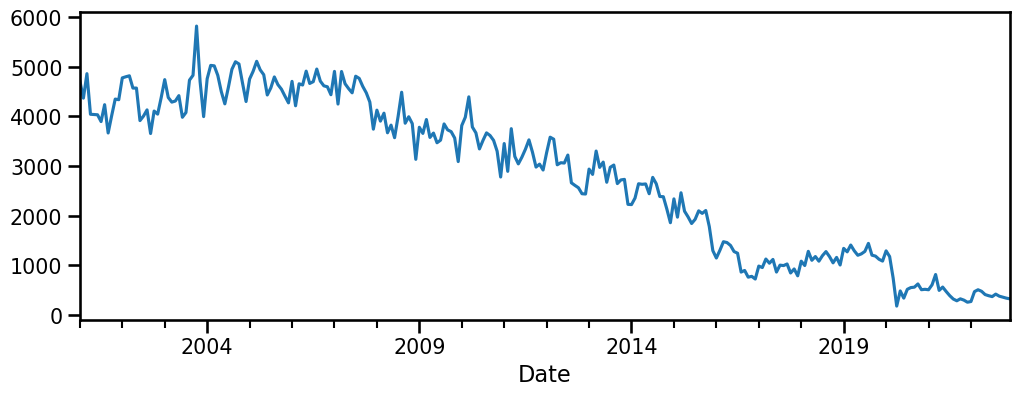

In [135]:
narcotics = unstacked_crime['NARCOTICS']
ax = narcotics.plot()

In [136]:
# Seasonal decomposition

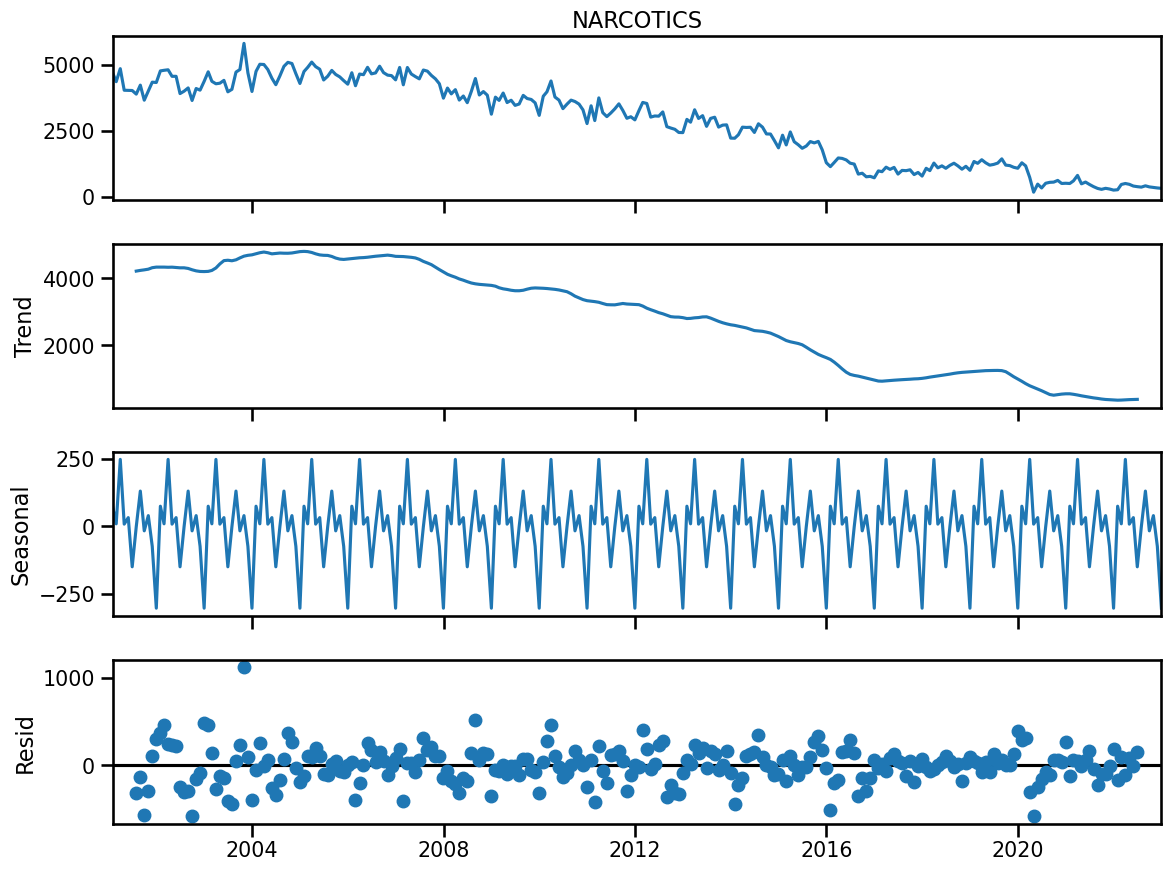

In [137]:
narc_decomp = tsa.seasonal_decompose(narcotics)
fig = narc_decomp.plot()
fig.set_size_inches(12,9)
fig.tight_layout()

In [138]:
# measure seasonal component 
seasonal_delta_narc = narc_decomp.seasonal.max() - narc_decomp.seasonal.min()

print(f'The seasonal component is {seasonal_delta_narc} which is ~{seasonal_delta_narc/float(narcotics.max() - narcotics.min()) * 100 : .2f}% of the variation in the time series')

The seasonal component is 550.6626984126985 which is ~ 9.76% of the variation in the time series


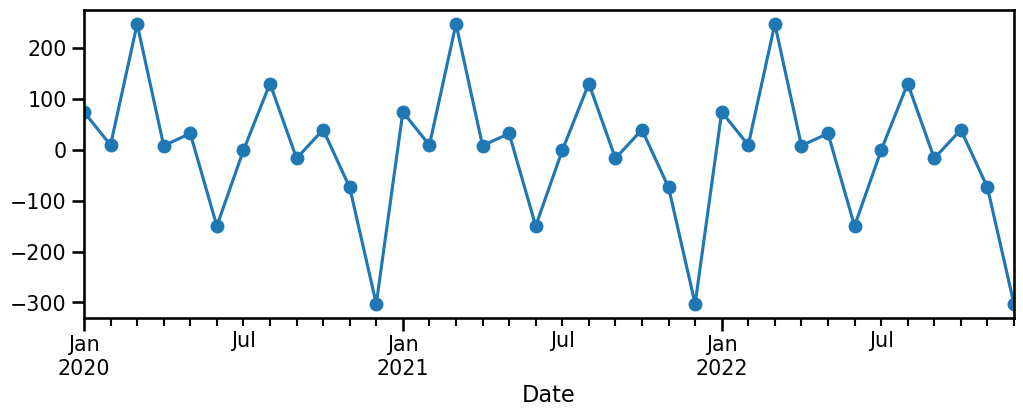

In [139]:
seasonal_narc = narc_decomp.seasonal
ax = seasonal_narc.loc['2020' : ].plot(marker = 'o')

In [140]:
# get d
d = ndiffs(narcotics)
d

1

In [141]:
# get D
D = nsdiffs(narcotics, m=12)
D

0

In [142]:
narc_diffs = narcotics.diff().dropna()

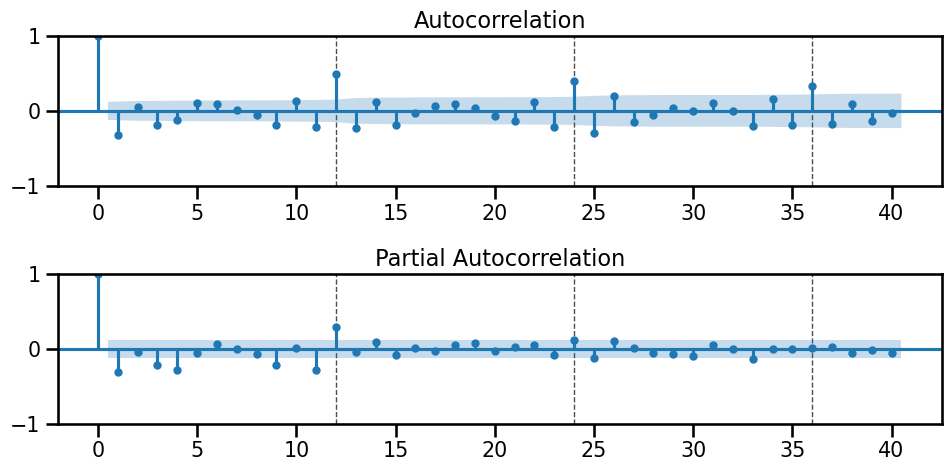

In [143]:
plot_acf_pacf(narc_diffs, annotate_seas=True, m = 12, method = 'ywm');

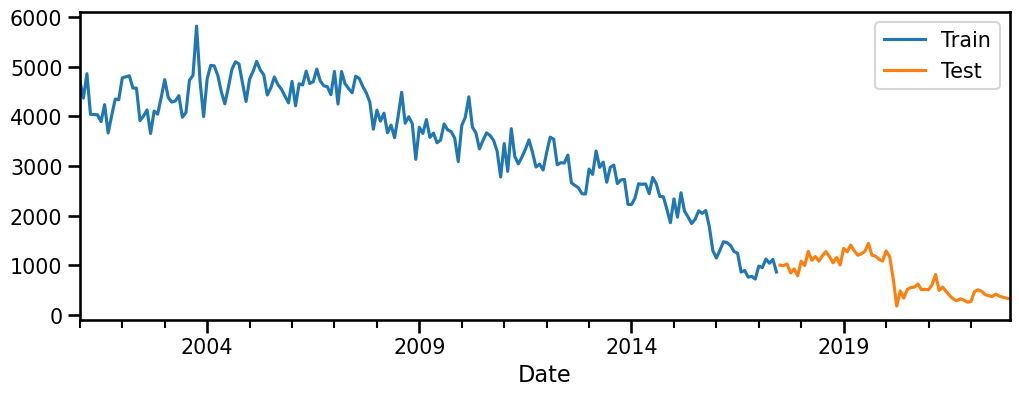

In [144]:
train_n, test_n = train_test_split(narcotics, test_size = .25)
ax = train_n.plot(label = 'Train')
test_n.plot(ax = ax, label = 'Test')
ax.legend();

In [145]:
# non seasonal components
p = 1
d = 0
q = 1

# seasonal components
P = 1
D = 0
Q = 0 
m = 12

sarima = tsa.ARIMA(train_n, order = (p,d,q), seasonal_order = (P, D, Q, m)).fit()

/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,114.183
- MSE = 2,061,146.026
- RMSE = 1,435.669
- R^2 = -13.300
- MAPE = 267.19%


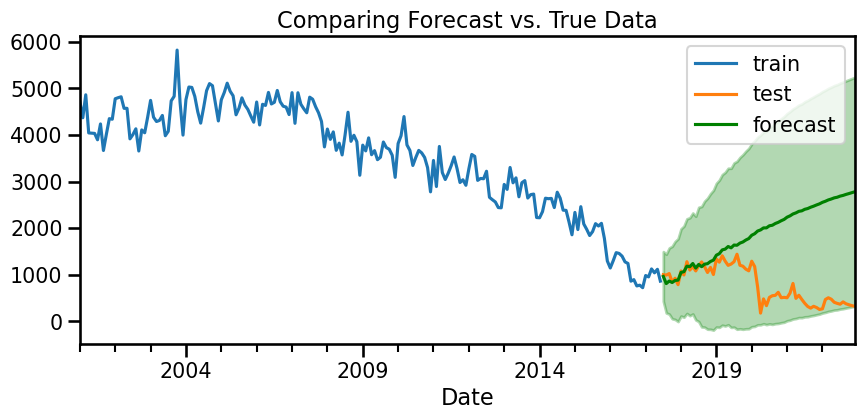

In [146]:
forecast_df = sarima.get_forecast(len(test_n)).summary_frame()
plot_forecast(train_n, test_n, forecast_df)
regression_metrics_ts(test_n, forecast_df['mean'])

In [147]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         NARCOTICS   No. Observations:                  198
Model:             ARIMA(1, 0, 1)x(1, 0, [], 12)   Log Likelihood               -1394.242
Date:                           Mon, 06 Nov 2023   AIC                           2798.484
Time:                                   09:25:27   BIC                           2814.926
Sample:                               01-31-2001   HQIC                          2805.139
                                    - 06-30-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3506.7740    817.592      4.289      0.000    1904.322    5109.225
ar.L1          0.9727      0.021     47.040      0.000       0.932       1.013
ma.L1         -0.3437      0.064     -5.409      0.000      -0.468      -0.219
ar.S.L12       0.5009      0.065      7.739      0.000       0.374       0.628
sigma2      7.402e+04   6256.591     11.831      0.000    6.18e+04    8.63e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                17.85
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -0.13
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

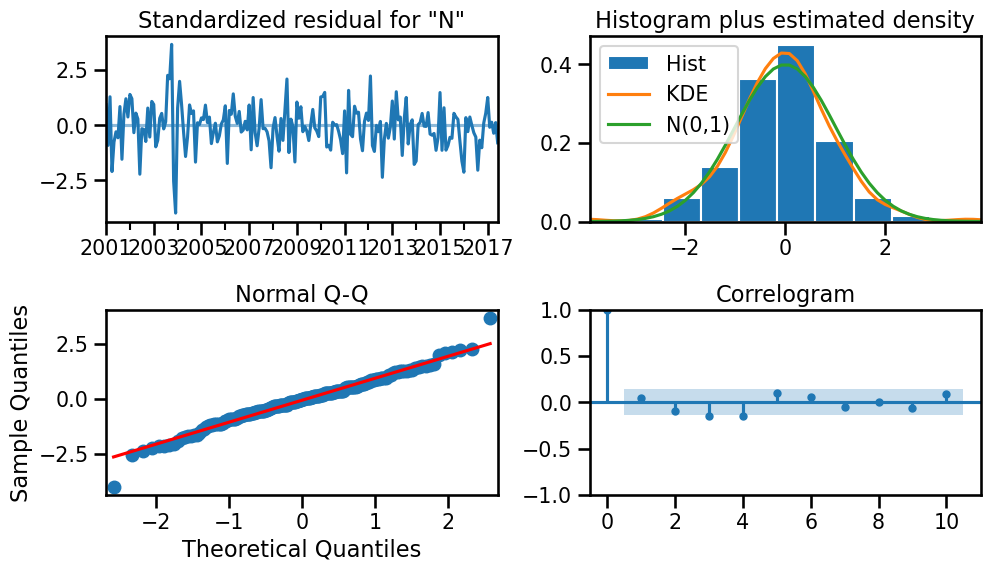

In [148]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(10, 6)
fig.tight_layout()

In [149]:
# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [0]          
q_values = range(0, 3)  
P_values = range (0, 3)
D_values = [0]
Q_values = range (0,3)
m = [12]

# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))

# Display first 10 combinations
pdqPDQm_to_try[:10]

[(0, 0, 0, 0, 0, 0, 12),
 (0, 0, 0, 0, 0, 1, 12),
 (0, 0, 0, 0, 0, 2, 12),
 (0, 0, 0, 1, 0, 0, 12),
 (0, 0, 0, 1, 0, 1, 12),
 (0, 0, 0, 1, 0, 2, 12),
 (0, 0, 0, 2, 0, 0, 12),
 (0, 0, 0, 2, 0, 1, 12),
 (0, 0, 0, 2, 0, 2, 12),
 (0, 0, 1, 0, 0, 0, 12)]

In [ ]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)

# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)
    
    model = tsa.ARIMA(train_n, order=order, seasonal_order = seasonal_order)
    try:                         
        result = model.fit()
        print(pdqPDQm, result.aic)      
   
    except:
        print(f'{pdqPDQm}: caused an error')
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdqPDQm = pdqPDQm

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)

Best AIC: 2776.4091411958157

Best pdqPDQm: (1, 0, 2, 1, 0, 1, 12)

In [151]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train_n,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2851.920, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2784.495, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2793.217, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2850.596, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2831.775, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2778.838, Time=0.60 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2765.339, Time=0.43 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2800.219, Time=0.16 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2766.087, Time=1.17 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2789.200, Time=0.36 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2770.286, Time=0.28 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept

In [152]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period
sarima = tsa.ARIMA(train_n, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 769.435
- MSE = 682,822.991
- RMSE = 826.331
- R^2 = -3.737
- MAPE = 131.94%


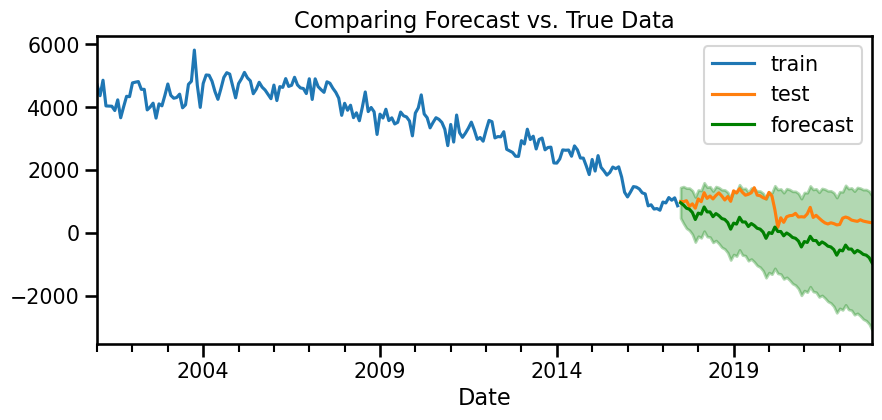

In [153]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test_n)).summary_frame()
# Plot the forecast with true values
plot_forecast(train_n, test_n, forecast_df)
# Obtain metrics
regression_metrics_ts(test_n, forecast_df["mean"])

Best model - Sarima

Regression Metrics: 

- MAE = 769.435
- MSE = 682,822.991
- RMSE = 826.331
- R^2 = -3.737
- MAPE = 131.94%

## Narcotics Follow Up

- Calculate the predicted net change in the number (raw counts) of this type of crime from the beginning of the forecast to the end.

- Convert the raw delta into a percent change.

In [176]:
len(test_n)

66

In [177]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period
final_narc = tsa.ARIMA(train_n, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 660.035
- MSE = 576,827.068
- RMSE = 759.491
- R^2 = -3.002
- MAPE = 139.16%


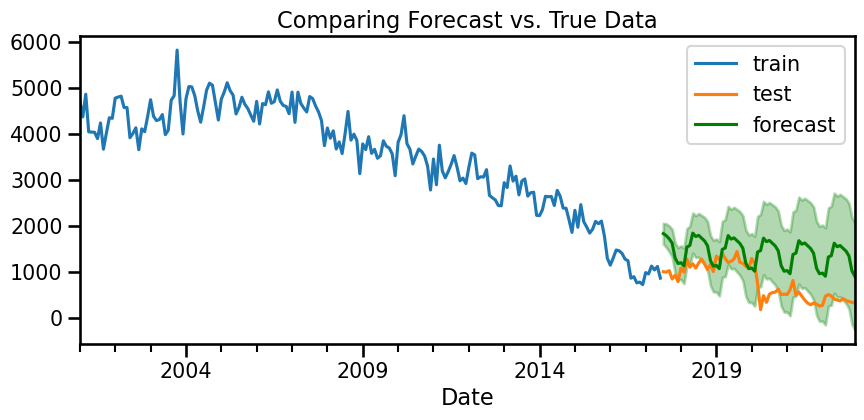

In [201]:
# Obtain summary of forecast as dataframe
forecast_df_n = sarima.get_forecast(len(test_n)).summary_frame()
# Plot the forecast with true values
plot_forecast(train_n, test_n, forecast_df_n)
# Obtain metrics
regression_metrics_ts(test_n, forecast_df_n["mean"])

In [202]:
forecast_df_n.index[0], forecast_df_n.index[-1]

(Timestamp('2017-07-31 00:00:00', freq='M'),
 Timestamp('2022-12-31 00:00:00', freq='M'))

In [203]:
starting_value_n = forecast_df_n['mean'].iloc[0]
starting_value_n

1832.5333664650204

In [205]:
final_value_n = forecast_df_n['mean'].iloc[-1]
final_value_n

904.4819893921205

In [206]:
change_n = final_value_n - starting_value_n
change_n

-928.0513770729

In [207]:
perc_change_n = (change_n / starting_value_n) * 100
perc_change_n

-50.643082088219906

Raw increase: ~ -928

Percentage change: ~ - 51

# Assault

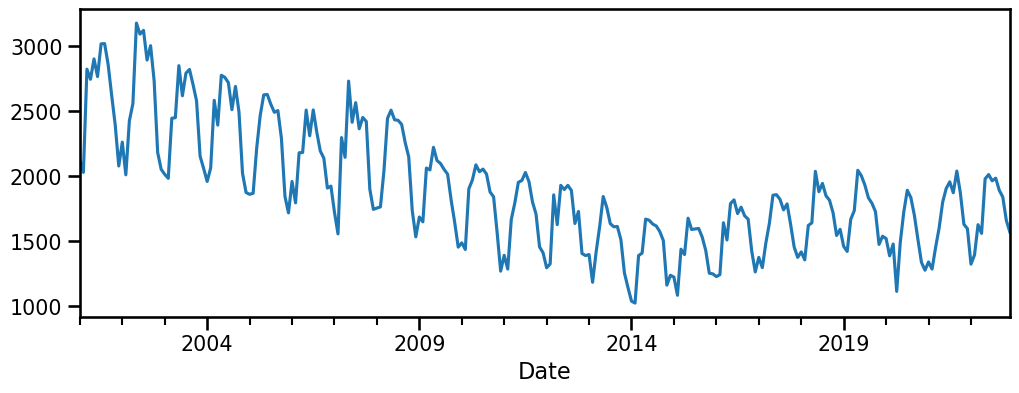

In [229]:
assault = unstacked_crime['ASSAULT']
ax = assault.plot()

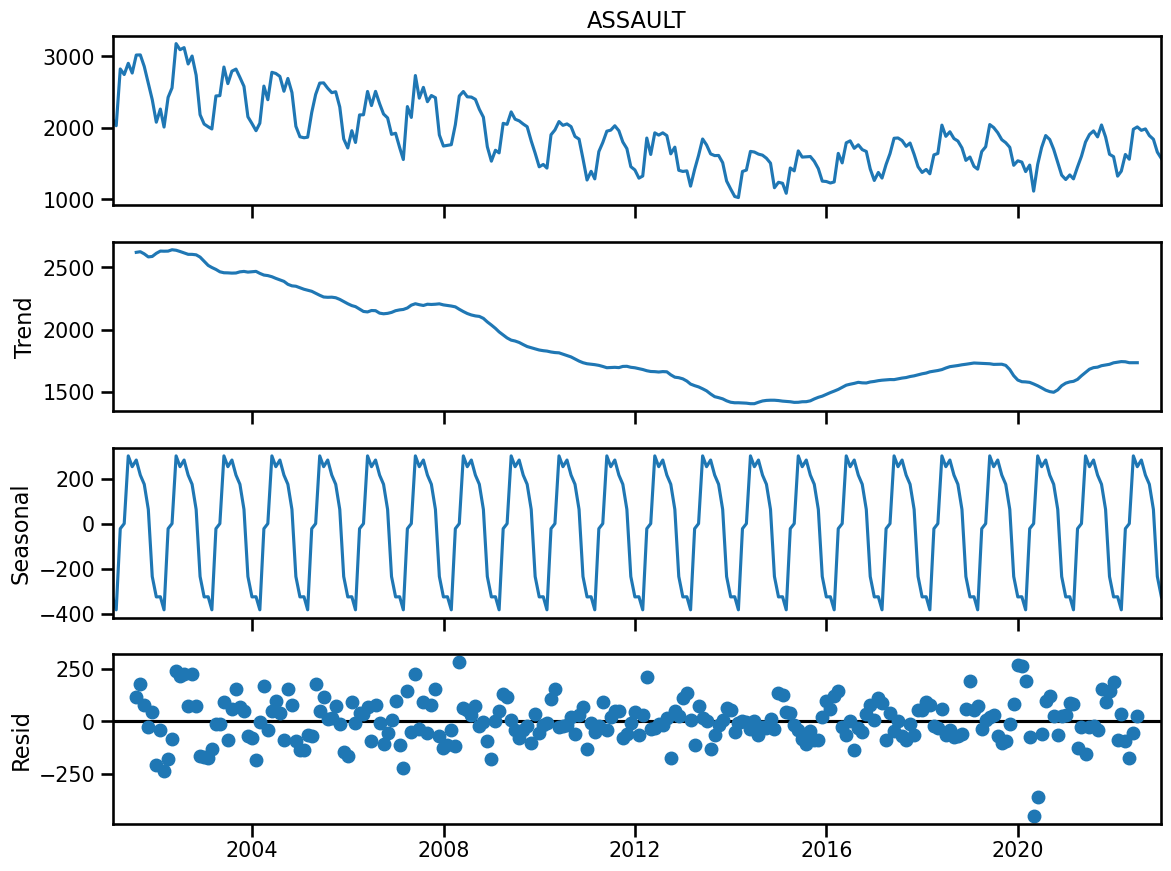

In [230]:
# seasonal decomposition 
assault_decomp = tsa.seasonal_decompose(assault)
fig = assault_decomp.plot()
fig.set_size_inches(12,9)
fig.tight_layout()

In [231]:
# measure seasonal component
seasonal_delta_assault = assault_decomp.seasonal.max() - assault_decomp.seasonal.min()
print(f'The seasonal component is {seasonal_delta_assault} which is ~{seasonal_delta_assault/float(assault.max() - assault.min()) * 100 : .2f}% of the variation in the time series')

The seasonal component is 684.8888888888889 which is ~ 31.75% of the variation in the time series


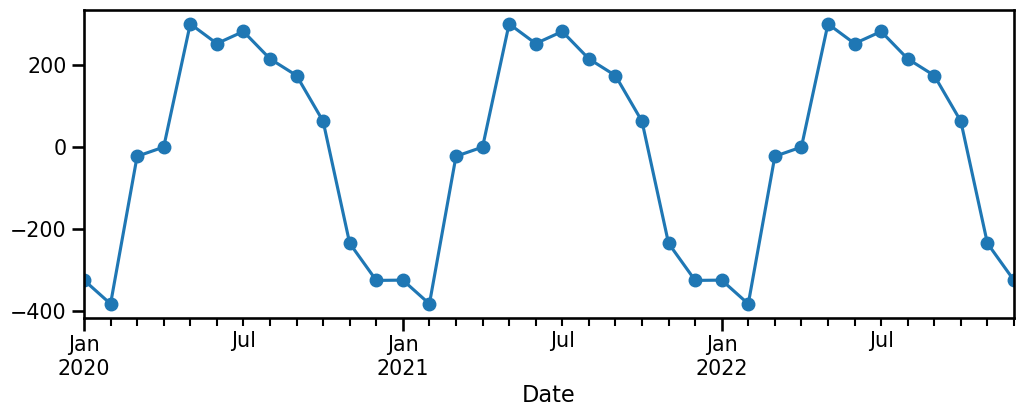

In [232]:
seasonal_assault = assault_decomp.seasonal
ax = seasonal_assault.loc['2020': ].plot(marker = 'o')

In [233]:
# get d
d = ndiffs(assault)
d

1

In [234]:
# get D 
D = nsdiffs(assault, m = 12)
D

0

In [235]:
assault_diffs = assault.diff().dropna()

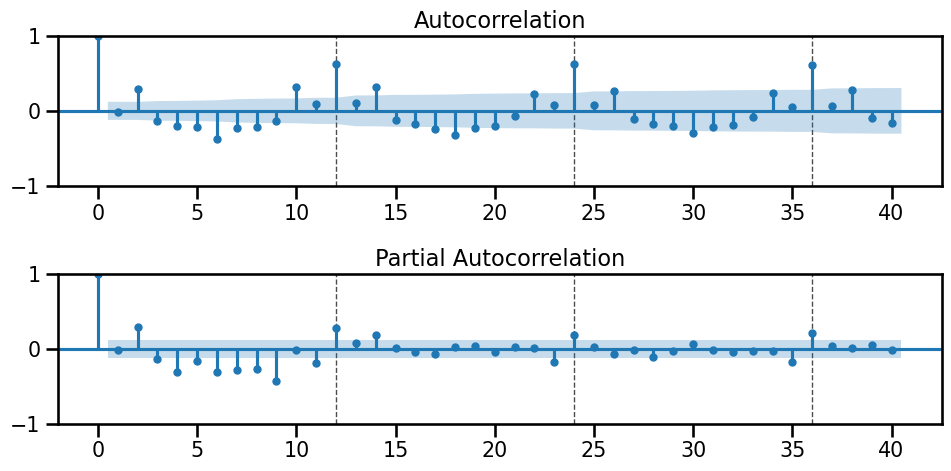

In [236]:
plot_acf_pacf(assault_diffs, annotate_seas=True, m = 12, method = 'ywm');

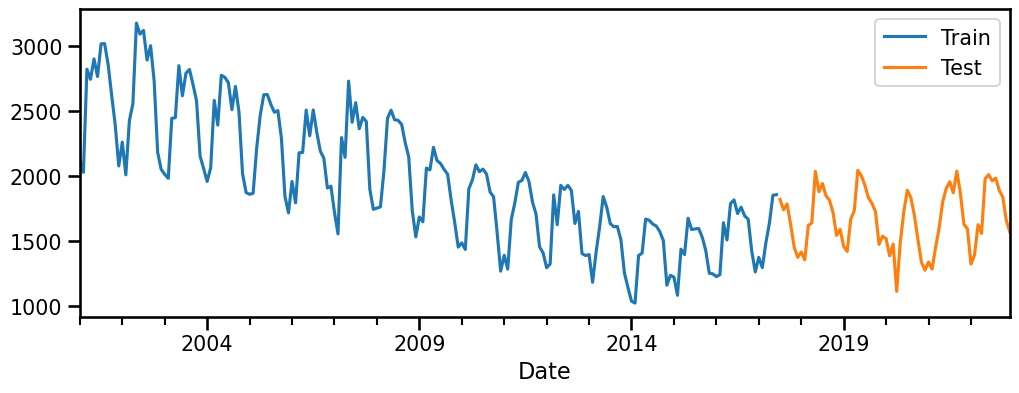

In [237]:
train_a, test_a = train_test_split(assault, test_size = .25)
ax = train_a.plot(label = 'Train')
test_a.plot(ax = ax, label = 'Test')
ax.legend();

In [238]:
# non seasonal components
p = 1
d = 0
q = 1

# seasonal components
P = 1
D = 0
Q = 0 
m = 12

sarima = tsa.ARIMA(train_a, order = (p,d,q), seasonal_order = (P, D, Q, m)).fit()

/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 117.686
- MSE = 27,525.174
- RMSE = 165.907
- R^2 = 0.474
- MAPE = 7.79%


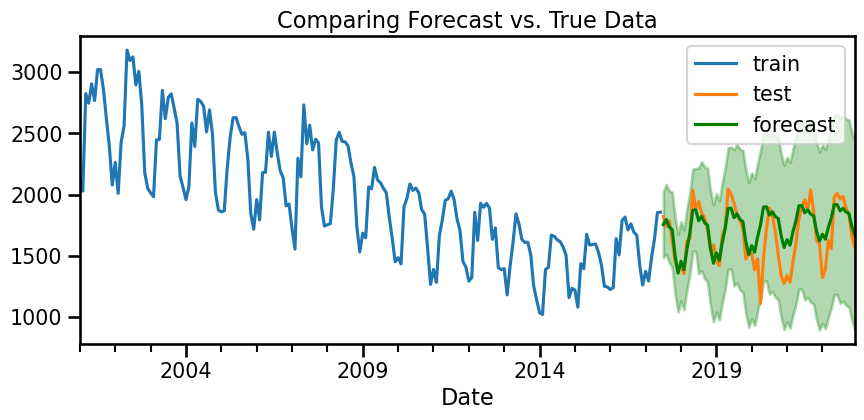

In [239]:
forecast_df_a = sarima.get_forecast(len(test_a)).summary_frame()
plot_forecast(train_a, test_a, forecast_df_a)
regression_metrics_ts(test_a, forecast_df_a['mean'])

In [240]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           ASSAULT   No. Observations:                  198
Model:             ARIMA(1, 0, 1)x(1, 0, [], 12)   Log Likelihood               -1265.498
Date:                           Mon, 06 Nov 2023   AIC                           2540.997
Time:                                   10:28:39   BIC                           2557.438
Sample:                               01-31-2001   HQIC                          2547.652
                                    - 06-30-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1974.2366    351.644      5.614      0.000    1285.027    2663.446
ar.L1          0.9180      0.044     20.705      0.000       0.831       1.005
ma.L1         -0.5961      0.081     -7.326      0.000      -0.756      -0.437
ar.S.L12       0.8720      0.029     30.355      0.000       0.816       0.928
sigma2      1.898e+04   1790.620     10.599      0.000    1.55e+04    2.25e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 3.83
Prob(Q):                              0.47   Prob(JB):                         0.15
Heteroskedasticity (H):               0.44   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

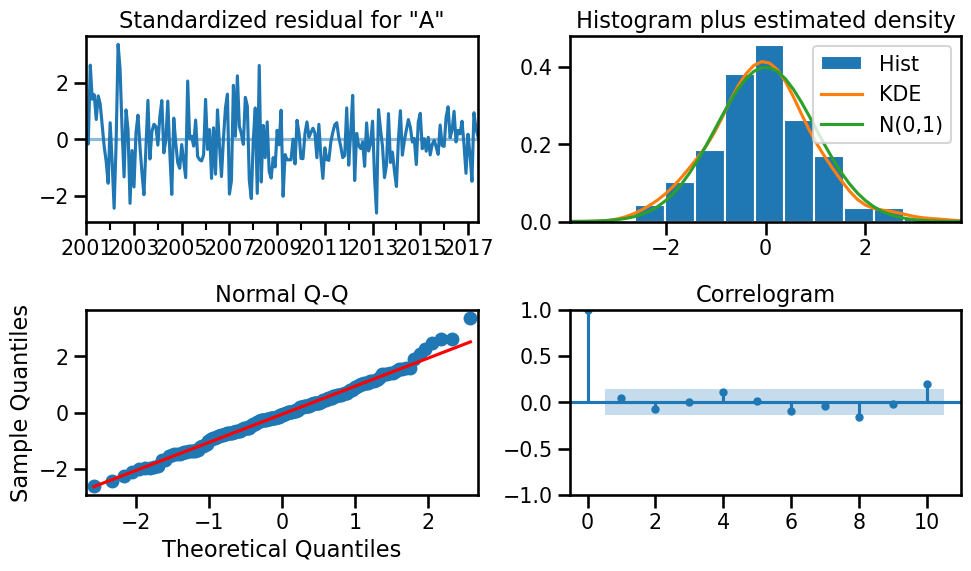

In [241]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(10, 6)
fig.tight_layout()

In [242]:
# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [0]          
q_values = range(0, 3)  
P_values = range (0, 3)
D_values = [0]
Q_values = range (0,3)
m = [12]

# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))

# Display first 10 combinations
pdqPDQm_to_try[:10]

[(0, 0, 0, 0, 0, 0, 12),
 (0, 0, 0, 0, 0, 1, 12),
 (0, 0, 0, 0, 0, 2, 12),
 (0, 0, 0, 1, 0, 0, 12),
 (0, 0, 0, 1, 0, 1, 12),
 (0, 0, 0, 1, 0, 2, 12),
 (0, 0, 0, 2, 0, 0, 12),
 (0, 0, 0, 2, 0, 1, 12),
 (0, 0, 0, 2, 0, 2, 12),
 (0, 0, 1, 0, 0, 0, 12)]

In [243]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)

# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)
    
    model = tsa.ARIMA(train_a, order=order, seasonal_order = seasonal_order)
    try:                         
        result = model.fit()
        print(pdqPDQm, result.aic)      
   
    except:
        print(f'{pdqPDQm}: caused an error')
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdqPDQm = pdqPDQm

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)

/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/py

(0, 0, 0, 0, 0, 0, 12) 3025.17714264386
(0, 0, 0, 0, 0, 1, 12) 2843.409680719429
(0, 0, 0, 0, 0, 2, 12) 2775.9965049079165
(0, 0, 0, 1, 0, 0, 12) 2631.2073362166634


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/py

(0, 0, 0, 1, 0, 1, 12) 2633.599270615933


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(0, 0, 0, 1, 0, 2, 12) 2632.6715800818743


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(0, 0, 0, 2, 0, 0, 12) 2633.1691713171776


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(0, 0, 0, 2, 0, 1, 12) 2635.4949140050744


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(0, 0, 0, 2, 0, 2, 12) 2597.148902073305
(0, 0, 1, 0, 0, 0, 12) 2880.1627078210954


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/py

(0, 0, 1, 0, 0, 1, 12) 2740.4371378531987


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(0, 0, 1, 0, 0, 2, 12) 2706.170263219664


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(0, 0, 1, 1, 0, 0, 12) 2588.640469390869


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(0, 0, 1, 1, 0, 1, 12) 2585.275795363429


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marcolaureano2/anaconda3/

(0, 0, 1, 1, 0, 2, 12) 2584.2602800953027
(0, 0, 1, 2, 0, 0, 12) 2584.50729754801


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marcolaureano2/anaconda3/

(0, 0, 1, 2, 0, 1, 12) 2593.5883590575677


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/

(0, 0, 1, 2, 0, 2, 12) 2562.851120348995
(0, 0, 2, 0, 0, 0, 12) 2766.972717148161
(0, 0, 2, 0, 0, 1, 12) 2685.704390347999


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2, 0, 0, 2, 12) 2650.982856751203


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2, 1, 0, 0, 12) 2575.6291181819615


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2, 1, 0, 1, 12) 2560.7658355908675


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/marcolaureano2/a

(0, 0, 2, 1, 0, 2, 12) 2569.268059939349
(0, 0, 2, 2, 0, 0, 12) 2557.789708749985


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/marcolaureano2/a

(0, 0, 2, 2, 0, 1, 12) 2579.1467033137637


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/

(0, 0, 2, 2, 0, 2, 12) 2534.796299043096
(1, 0, 0, 0, 0, 0, 12) 2698.7235258194046
(1, 0, 0, 0, 0, 1, 12) 2629.907330251255


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 0, 0, 2, 12) 2606.39818186771


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 1, 0, 0, 12) 2558.095324680109


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 1, 0, 1, 12) 2507.451232509477


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 1, 0, 2, 12) 2501.098352084645


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 2, 0, 0, 12) 2526.310211593159


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 2, 0, 1, 12) 2503.9094776445972


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 0, 2, 0, 2, 12) 2501.172056608727
(1, 0, 1, 0, 0, 0, 12) 2700.668011091314


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/py

(1, 0, 1, 0, 0, 1, 12) 2630.656578651741


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 1, 0, 0, 2, 12) 2605.428314830509


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 1, 1, 0, 0, 12) 2540.996898941138


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marcolaureano2/anaconda3/

(1, 0, 1, 1, 0, 1, 12) 2494.731610790326
(1, 0, 1, 1, 0, 2, 12) 2464.9565223474765


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 1, 2, 0, 0, 12) 2496.171846953439


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 1, 2, 0, 1, 12) 2479.1983132734586


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marcolaureano2/anaconda3/

(1, 0, 1, 2, 0, 2, 12) 2476.139438630321
(1, 0, 2, 0, 0, 0, 12) 2667.7978580302774
(1, 0, 2, 0, 0, 1, 12) 2626.490709206443


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 2, 0, 0, 2, 12) 2598.958017051982


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 2, 1, 0, 0, 12): caused an error


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 2, 1, 0, 1, 12) 14.0


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 2, 1, 0, 2, 12) 2465.3853563308594


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marcolaureano2/anaconda3/

(1, 0, 2, 2, 0, 0, 12) 2497.3804882170207


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 0, 2, 2, 0, 1, 12) 2497.977277265596


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/

(1, 0, 2, 2, 0, 2, 12) 2475.2640647035387
(2, 0, 0, 0, 0, 0, 12) 2700.6303571858043
(2, 0, 0, 0, 0, 1, 12) 2630.2059472802957


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 0, 0, 0, 0, 2, 12) 2604.113356789071


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 0, 0, 1, 0, 0, 12) 2549.9174273506896


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marcolaureano2/anaconda3/

(2, 0, 0, 1, 0, 1, 12) 2500.178795390104
(2, 0, 0, 1, 0, 2, 12) 2477.6706001109587


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 0, 0, 2, 0, 0, 12) 2507.637995817666


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 0, 0, 2, 0, 1, 12) 2480.148861331628


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 0, 0, 2, 0, 2, 12) 2488.6348604820278
(2, 0, 1, 0, 0, 0, 12) 2687.8204614877354


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users

(2, 0, 1, 0, 0, 1, 12) 2626.0621429855782


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users

(2, 0, 1, 0, 0, 2, 12) 2602.712616629112


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users

(2, 0, 1, 1, 0, 0, 12) 2544.8280781279736
(2, 0, 1, 1, 0, 1, 12) 2510.7325121633176


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users

(2, 0, 1, 1, 0, 2, 12) 2492.5638509571636


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users

(2, 0, 1, 2, 0, 0, 12) 2506.6172455792184
(2, 0, 1, 2, 0, 1, 12) 2511.065786026147


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users

(2, 0, 1, 2, 0, 2, 12) 2476.92452054738
(2, 0, 2, 0, 0, 0, 12) 2668.840439303978


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 0, 2, 0, 0, 1, 12) 2627.784182493955


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 0, 2, 0, 0, 2, 12) 2600.9576106519226


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 0, 2, 1, 0, 0, 12) 2541.883345537297


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marcolaureano2/anaconda3/

(2, 0, 2, 1, 0, 1, 12) 2484.878539645816


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 0, 2, 1, 0, 2, 12) 2467.278564027124
(2, 0, 2, 2, 0, 0, 12) 2499.16807867388


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 0, 2, 2, 0, 1, 12): caused an error


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 0, 2, 2, 0, 2, 12) 2483.3255408242576
Best AIC: 14.0
Best pdqPDQm: (1, 0, 2, 1, 0, 1, 12)


/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [244]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train_a,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2692.435, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2553.931, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2626.489, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2690.443, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2694.275, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2625.706, Time=0.17 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2573.857, Time=0.10 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2545.479, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2675.302, Time=0.14 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=2

In [245]:
# Orders for non seasonal components
p = 3 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 2  # Seasonal MA
m = 12 # Seasonal period
sarima = tsa.ARIMA(train_a, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 269.067
- MSE = 98,165.017
- RMSE = 313.313
- R^2 = -0.877
- MAPE = 16.48%


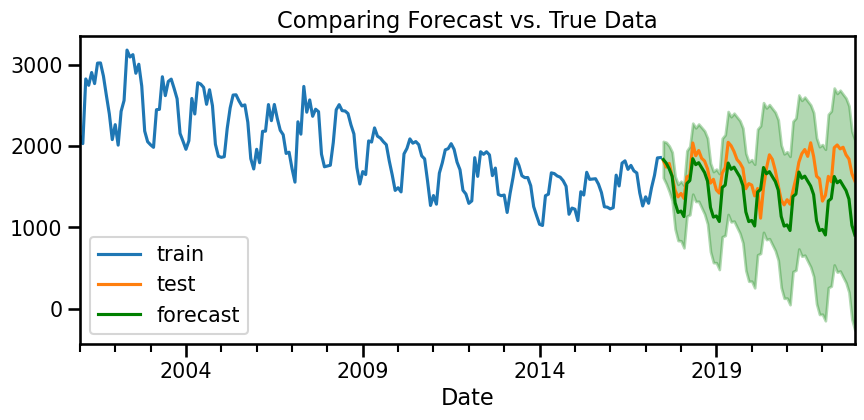

In [246]:
# Obtain summary of forecast as dataframe
forecast_df_a = sarima.get_forecast(len(test_a)).summary_frame()
# Plot the forecast with true values
plot_forecast(train_a, test_a, forecast_df_a)
# Obtain metrics
regression_metrics_ts(test_a, forecast_df_a["mean"])

Both models were pretty close but we will be going with the ARIMA


------------------------------------------------------------
Regression Metrics: 

------------------------------------------------------------

- MAE = 117.686
- MSE = 27,525.174
- RMSE = 165.907
- R^2 = 0.474
- MAPE = 7.79%



# Assault Follow Up

In [247]:
len(test_a)

66

In [261]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 0  # nonseasonal differencing
q = 1  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period
final_assault = tsa.ARIMA(train_a, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 117.686
- MSE = 27,525.174
- RMSE = 165.907
- R^2 = 0.474
- MAPE = 7.79%


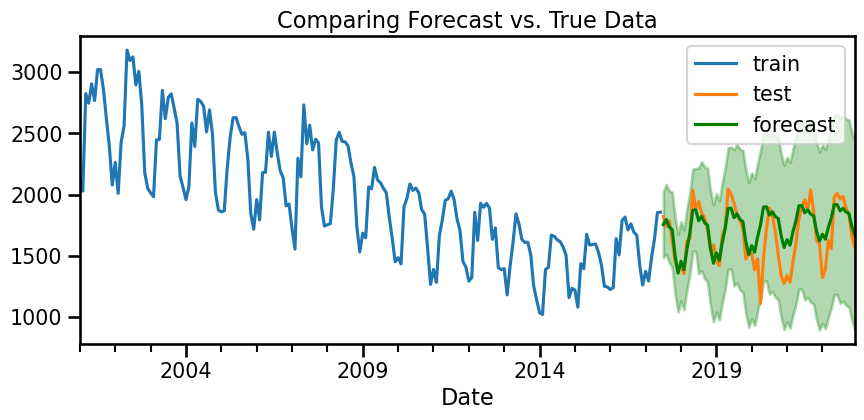

In [262]:
# Obtain summary of forecast as dataframe
forecast_df_a = final_assault.get_forecast(len(test_a)).summary_frame()
# Plot the forecast with true values
plot_forecast(train_a, test_a, forecast_df_a)
# Obtain metrics
regression_metrics_ts(test_a, forecast_df_a["mean"])

In [263]:
forecast_df_a.index[0], forecast_df_a.index[-1]

(Timestamp('2017-07-31 00:00:00', freq='M'),
 Timestamp('2022-12-31 00:00:00', freq='M'))

In [264]:
starting_value_a = forecast_df_a['mean'].iloc[0]
starting_value_a

1755.113780009895

In [265]:
final_value_a = forecast_df_a['mean'].iloc[-1]
final_value_a

1666.4741827628766

In [266]:
change_a = final_value_a - starting_value_a
change_a

-88.6395972470184

In [267]:
perc_change_a = (change_a / starting_value_a) * 100
perc_change_a

-5.050361877195145

Raw increase: ~ -89

Percentage change: ~ -5

# Final Evaluation

In [ ]:
- Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?

-Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?

Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?
